# Monte-Carlo-Simulation zur Demonstration des risikobasierten Anreizsystems im IPA-Zielkostenprozess

In [1]:
# author: leopold mueller (mueller@tu-berlin.de)
# version: ma2025_v1.0

import matplotlib.pyplot as plt
from pylab import *
import numpy as np
from numpy import linalg as la
import pandas as pd

import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches

import mcerp as mcerp
from mcerp import correlate, correlation_matrix, plotcorr, lhd
from mcerp import Normal, Gamma, Beta, Uniform
from mcerp import uv, stats

from scipy import stats as stats 
from scipy.stats import pearsonr, rv_continuous, beta, genextreme, rv_histogram, gaussian_kde
from scipy.linalg import eigh
import scipy.optimize as opt

from fitter import Fitter, get_common_distributions, get_distributions

# simulation settings
n_samples = 50000
mcerp.npts = n_samples

# plot theme
custom_params = {"figure.dpi": 200, "lines.linewidth": 1.5, "axes.linewidth": 0.75, "xtick.major.width": 0.75, "ytick.major.width": 0.75, "axes.spines.right": True, "axes.spines.top": True, "axes.edgecolor":"black", "grid.color":"white"}
sns.set_theme(style="ticks", rc=custom_params)

## Datengrundlage

In [2]:
# import data
# convert data to dataframe and select relevant columns

# excel filepath
path_data =r"C:\Users\Leopold\Documents\Testprojekte\Masterarbeit\mcs_daten.xlsx"

# partners data
partners_data = pd.read_excel(path_data, sheet_name="partner") 
partners_raw = pd.DataFrame(partners_data, columns= ["partner","gewerk","db","bb","db_prob","bb_prob","b"])
partners_raw.drop(partners_raw.index[-1], inplace=True)
partners_raw

partner         gewerk    db    bb   db_prob   bb_prob         b
0  partner1         erdbau  0.18  0.15  0.020333  0.016944  0.151576
1  partner2  rohbau_ausbau  0.16  0.10  0.092813  0.058008  0.518915
2  partner3            tga  0.15  0.12  0.031563  0.025250  0.225877
3  partner4        planung  0.80  0.12  0.077231  0.011585  0.103632

In [3]:
# quantities data
quantities_data = pd.read_excel(path_data, sheet_name="projekt_mengen") 
quantities_raw = pd.DataFrame(quantities_data, columns= ["bgf","kg_200_gr","kg_310_bgi","kg_320_grf","kg_330_awf","kg_340_iwf","kg_350_def","kg_360_daf","kg_500_auf"])
quantities_raw

bgf  kg_200_gr  kg_310_bgi  kg_320_grf  kg_330_awf  kg_340_iwf  \
0  1521.22       2500     1690.25         757     1331.98     1265.23   

   kg_350_def  kg_360_daf  kg_500_auf  
0      764.22      764.22        1743

In [4]:
# phase 1 data
phase1_data = pd.read_excel(path_data, sheet_name="k_det") 
phase1_raw = pd.DataFrame(phase1_data, columns= ["partner1_k_phase1_det","partner2_k_phase1_det","partner3_k_phase1_det","partner4_k_phase1_det"])
phase1_raw

partner1_k_phase1_det  partner2_k_phase1_det  partner3_k_phase1_det  \
0           54086.134925          132464.806996           48050.301489   

   partner4_k_phase1_det  
0          279923.440062

In [5]:
# phase 2 data deterministic
phase2_det_data = pd.read_excel(path_data, sheet_name="k_det") 
phase2_det_raw = pd.DataFrame(phase1_data, columns= ["partner1_k_phase2_det","partner2_k_phase2_det","partner3_k_phase2_det","partner4_k_phase2_det"])
phase2_det_raw

partner1_k_phase2_det  partner2_k_phase2_det  partner3_k_phase2_det  \
0          487620.364852           2.649296e+06          961006.029785   

   partner4_k_phase2_det  
0          183026.864656

In [6]:
# phase 2 data 
phase2_data = pd.read_excel(path_data, sheet_name="projekt_referenz") 
phase2_raw = pd.DataFrame(phase2_data, columns= ["kg_310_korrigiert_db","kg_320_korrigiert_db","kg_330_korrigiert_db","kg_340_korrigiert_db","kg_350_korrigiert_db",
                                                 "kg_360_korrigiert_db","kg_380_korrigiert_db","kg_390_korrigiert_db","kg_410_korrigiert_db","kg_420_korrigiert_db",
                                                 "kg_430_korrigiert_db","kg_440_korrigiert_db","kg_450_korrigiert_db","kg_460_korrigiert_db","kg_470_korrigiert_db",
                                                 "kg_480_korrigiert_db","kg_490_korrigiert_db","kg_500_korrigiert_db","kg_600_korrigiert_db","kg_700_korrigiert_db_phase2"])                                               
phase2_raw.drop(phase2_raw.index[-1], inplace=True)
phase2_raw


kg_310_korrigiert_db  kg_320_korrigiert_db  kg_330_korrigiert_db  \
0              35.767474            297.924515            579.621396   
1             117.240244            476.605060           1207.916863   
2              48.734377            298.524884            508.565905   
3              84.293548            370.648680            526.833028   
4             166.210693            477.258328            778.593604   
5              85.190318            546.291163            936.365292   
6             105.451838            358.248183           1336.458079   
7              19.447175            557.511401            700.494440   
8              19.776376            314.596655            623.454237   
9              37.231073            890.559757            479.475699   
10             60.207276            392.361708            543.168398   

    kg_340_korrigiert_db  kg_350_korrigiert_db  kg_360_korrigiert_db  \
0             404.110448            363.647312            404.375317   
1             345.583255            355.250969            542.751648   
2             251.069210            416.117837            446.966233   
3             251.863817            357.131538            366.525554   
4             355.984984            405.713335            619.287853   
5             354.831863            657.515879            748.705115   
6             393.402490            478.001085            952.566393   
7             307.781483            465.803480            545.183022   
8             353.705563            334.310188            393.279470   
9             303.448903            347.428069            384.052901   
10            188.532835                   NaN            306.055348   

    kg_380_korrigiert_db  kg_390_korrigiert_db  kg_410_korrigiert_db  \
0              15.327079             40.127635             63.729448   
1               2.357333            211.771497             69.838783   
2                    NaN            129.079433             92.566222   
3                    NaN            106.000525             72.626279   
4              34.820142            117.433038             28.382896   
5              38.814883            143.604771             78.346348   
6              25.488953            166.213176             52.932169   
7               8.131737            100.006097             90.946436   
8              22.026293             85.217282             54.470705   
9               2.080261             25.966553             70.862523   
10                   NaN             51.651658             50.866479   

    kg_420_korrigiert_db  kg_430_korrigiert_db  kg_440_korrigiert_db  \
0             130.460130            104.348511            177.054942   
1             129.053023            173.252192            134.904092   
2             171.346365             10.954056            245.914094   
3             180.733011                   NaN             89.564989   
4             102.876316             70.152384            139.100078   
5              68.771145            270.483913            195.907411   
6             171.232089            107.207429            191.366460   
7             176.688396            170.764406            236.779718   
8              98.091704             89.414408            142.477984   
9             119.013491             58.124303             85.291767   
10            152.130395              9.417890             88.167741   

    kg_450_korrigiert_db  kg_460_korrigiert_db  kg_470_korrigiert_db  \
0              67.710312                   NaN                   NaN   
1              53.995479             27.545442              2.466889   
2              44.404001                   NaN                   NaN   
3              15.077411                   NaN                   NaN   
4              60.379861             12.410377                   NaN   
5              45.819736             39.640510                   NaN   
6              63.796814             27.

In [7]:
# deterministic values
# k_ist phase 1 (constant)

cost_phase1_det = phase1_raw.sum().sum()
print("Phase 1 K_ist: ",cost_phase1_det.round())

# k_det phase 1+2
cost_phase2_det = phase2_det_raw.sum().sum()
print(cost_phase2_det.round())
cost_phase12_det = cost_phase1_det + cost_phase2_det
print("Phase 1+2 det.: ",cost_phase12_det)

Phase 1 K_ist:  514525.0
4280949.0
Phase 1+2 det.:  4795474.082682978


In [8]:
# incentive scheme data
bb_prob = round(sum(partners_raw["bb_prob"]),4)
db_prob = round(sum(partners_raw["db_prob"]),4)
print(bb_prob, db_prob)

0.1118 0.2219


In [9]:
# labels
labels = pd.read_excel(path_data, sheet_name="labels") 
labels_raw = pd.DataFrame(labels, columns= ["title","text"])
labels_raw

labels_title = list(labels_raw["title"])
labels_text = list(labels_raw["text"])
print(labels_title)
print(labels_text)

['KG 310', 'KG 320', 'KG 330', 'KG 340', 'KG 350', 'KG 360', 'KG 380', 'KG 390', 'KG 410', 'KG 420', 'KG 430', 'KG 440', 'KG 450', 'KG 460', 'KG 470', 'KG 480', 'KG 490', 'KG 500', 'KG 600', 'KG 700']
['Baugrube', 'Gründung', 'Außenwände', 'Innenwände', 'Decken', 'Dächer', 'Einbauten', 'Sonstiges', 'Wasser, Gas', 'Wärme', 'RLT', 'ELT', 'Komm./IT', 'Förderanlagen', 'Nutzungsspez.', 'GA', 'Sonstiges', 'Außenanlagen', 'Ausstattung', 'Planung (Phase 2)']


## Zufallsvariablen

In [10]:
# k_prob phase 2 (datafitting)

phase2_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   kg_310_korrigiert_db         11 non-null     float64
 1   kg_320_korrigiert_db         11 non-null     float64
 2   kg_330_korrigiert_db         11 non-null     float64
 3   kg_340_korrigiert_db         11 non-null     float64
 4   kg_350_korrigiert_db         10 non-null     float64
 5   kg_360_korrigiert_db         11 non-null     float64
 6   kg_380_korrigiert_db         8 non-null      float64
 7   kg_390_korrigiert_db         11 non-null     float64
 8   kg_410_korrigiert_db         11 non-null     float64
 9   kg_420_korrigiert_db         11 non-null     float64
 10  kg_430_korrigiert_db         10 non-null     float64
 11  kg_440_korrigiert_db         11 non-null     float64
 12  kg_450_korrigiert_db         11 non-null     float64
 13  kg_460_korrigiert_db  

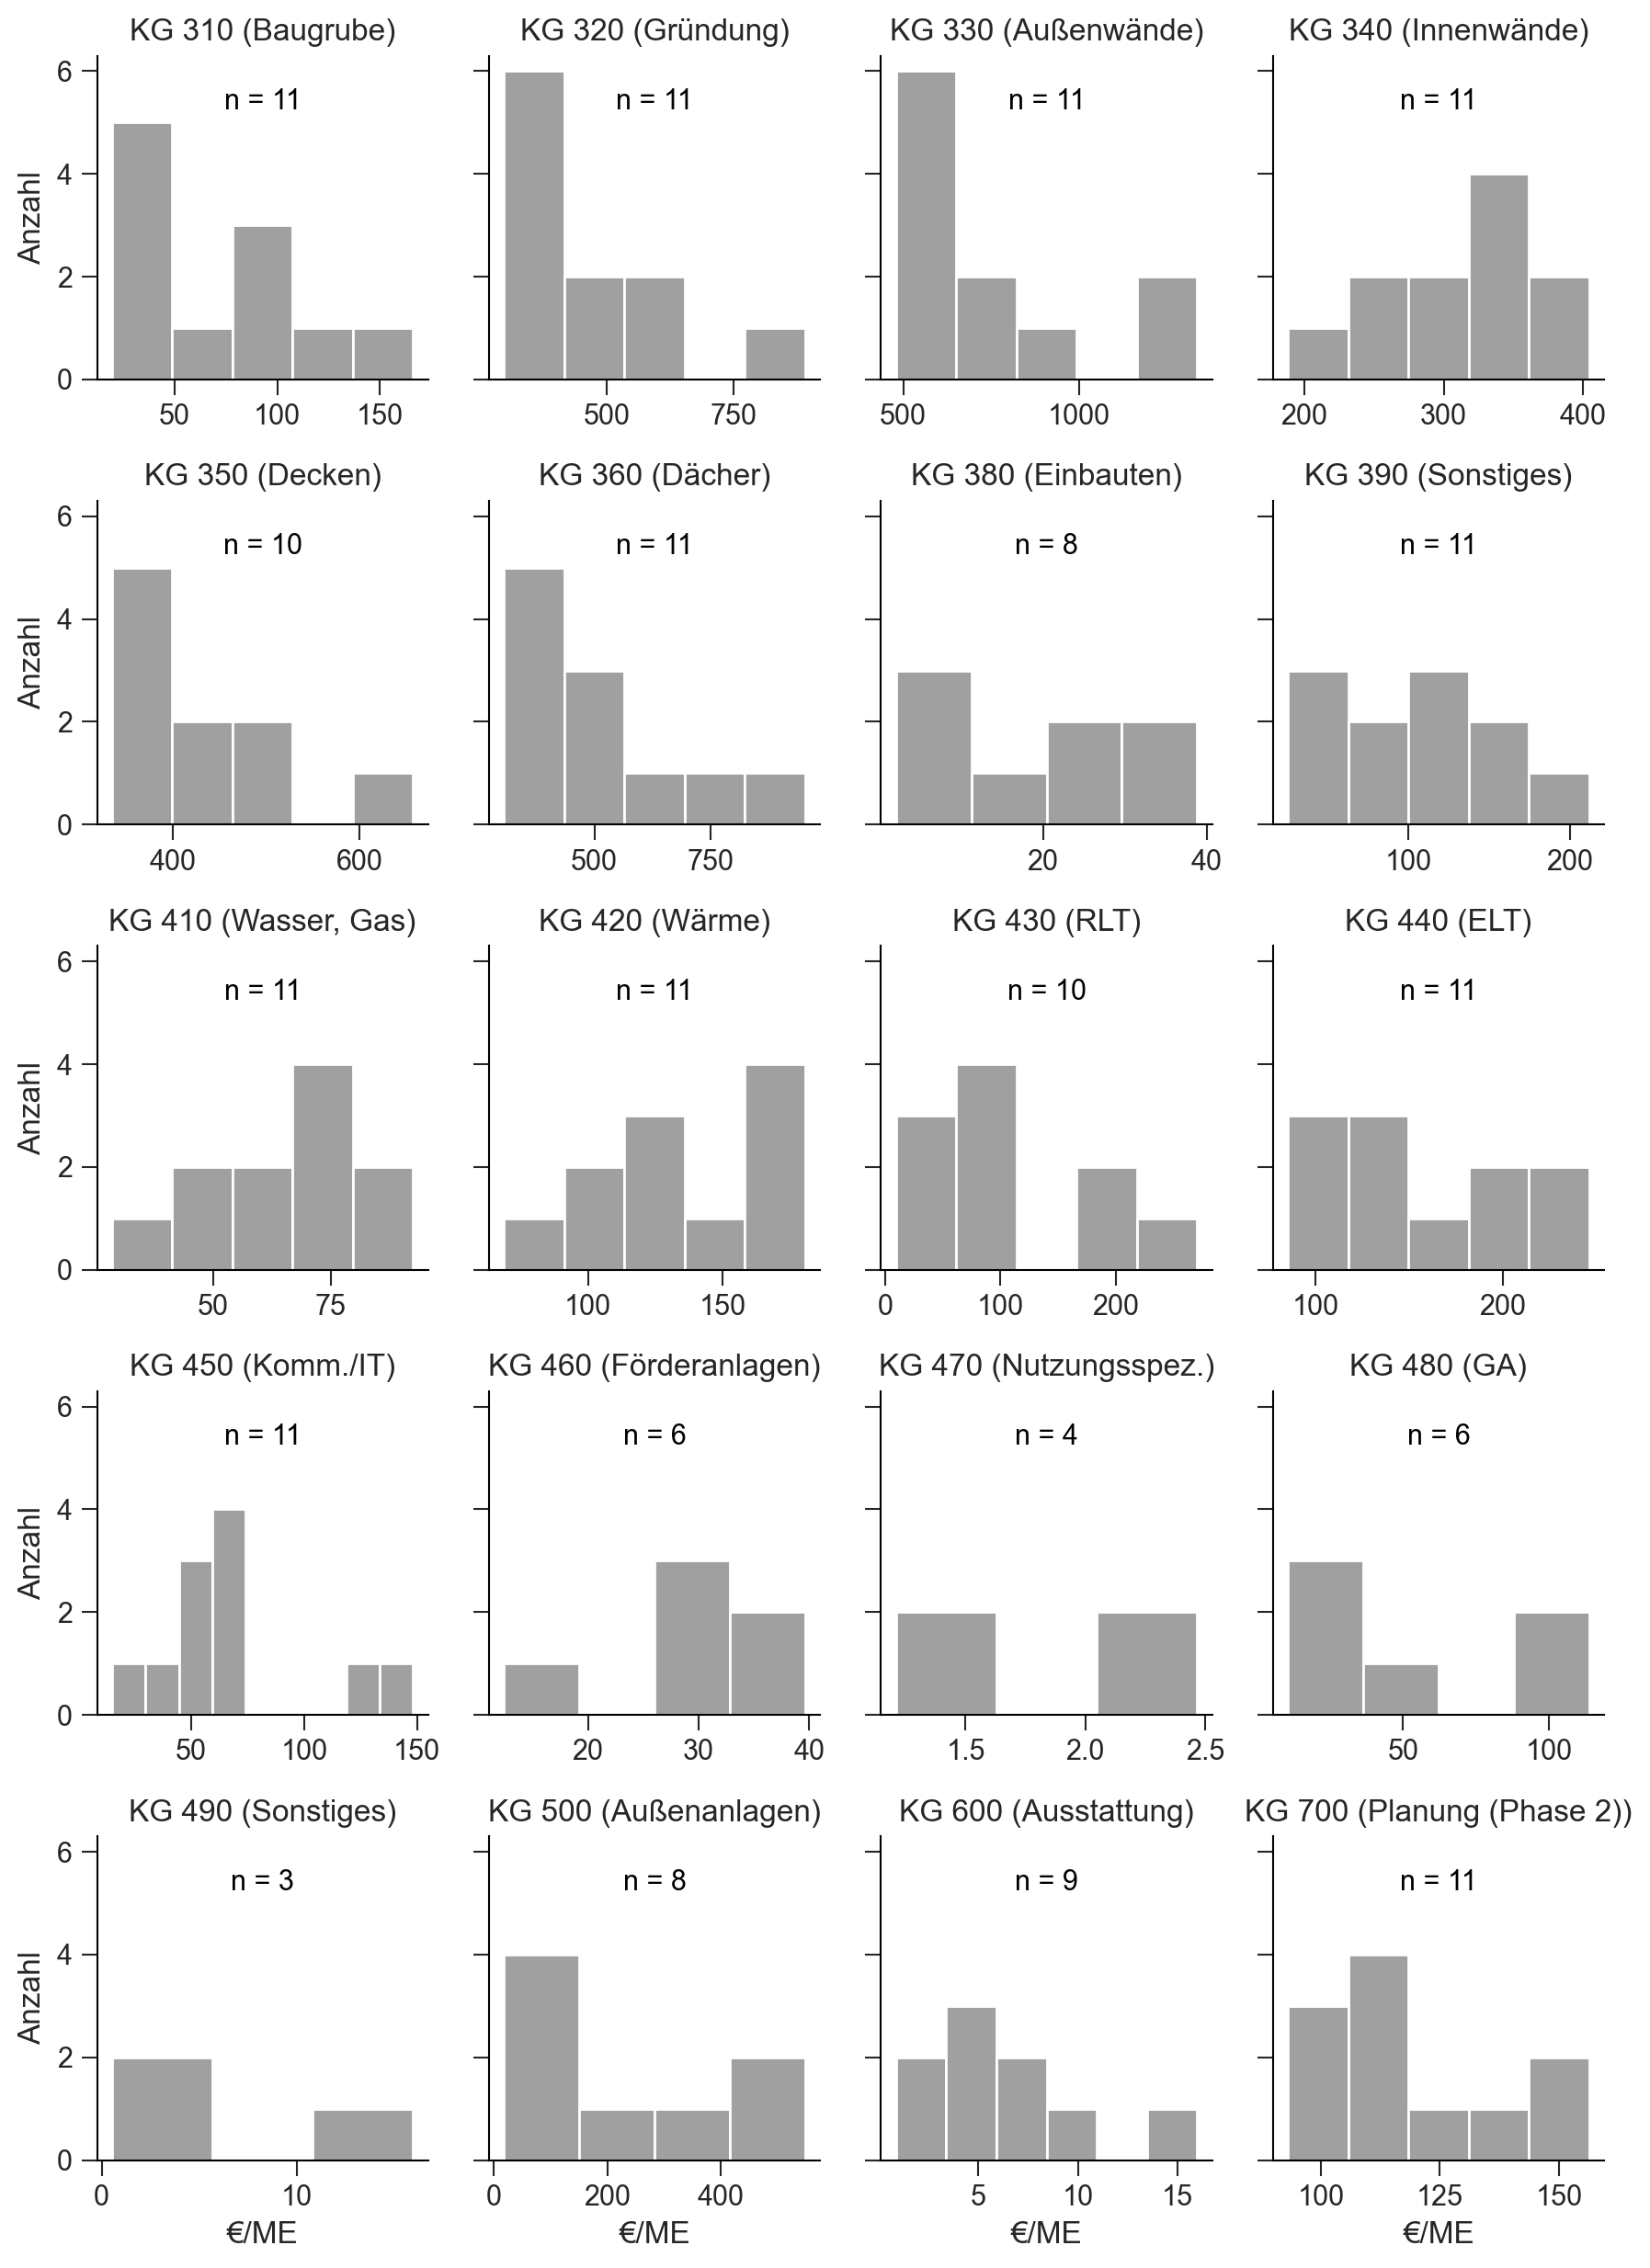

In [11]:
# datafitting phase 2 raw data
# long format for plot
phase2_long = phase2_raw.melt(var_name="KG", value_name="€/ME")

# plot raw data with FacetGrid
g = sns.FacetGrid(phase2_long, col="KG", col_wrap=4, height=2.5, aspect=0.9, sharex=False, sharey=True)
g.map_dataframe(sns.histplot, x="€/ME", kde=False, color="gray")
plt.tight_layout()

# Set custom titles
for ax, title, text in zip(g.axes.flat, labels_title, labels_text):
    ax.set_title(title+" ("+text+")")

# Add data count and selective ylabel
for i, (ax, (kg, group)) in enumerate(zip(g.axes.flat, phase2_long.groupby("KG"))):
    n = len(group.dropna().values)
    
    # Add 'n=' text in the center of each plot
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.text(
        x=(xlim[0] + xlim[1]) / 2,
        y=(ylim[1]) * 0.9,
        s=f"n = {n}",
        ha="center",
        va="top",
        fontsize=11,
        color="black"
    )

    # Only show 'Anzahl' on y-axis of leftmost column
    if i % g._ncol == 0:
        ax.set_ylabel("Anzahl")
    else:
        ax.set_ylabel("")

# Improve layout
plt.tight_layout()
plt.show()

In [ ]:
# list of distributions to fit
distributions_to_fit = ["uniform", "truncnorm", "foldnorm", "beta", "truncweibull_min"] #, "weibull_min", "foldnorm", "fisk", "genlogistic", "gamma", "uniform", "beta", "norm", "triang"]

# prepare color mapping for distributions
colors = {
    "uniform": "red",
    "truncnorm": "purple",
    "foldnorm":"blue",
    "beta": "green",
    "truncweibull_min":"orange",
    }
#     "weibull_min": "green",
#     "foldnorm": "red",
#     "fisk": "brown",
#     "genlogistic": "teal"
#     "triang": "red",
#     "norm": "red",
#     "gamma": "green",
#     "beta": "orange",
#     "uniform": "purple"
# }


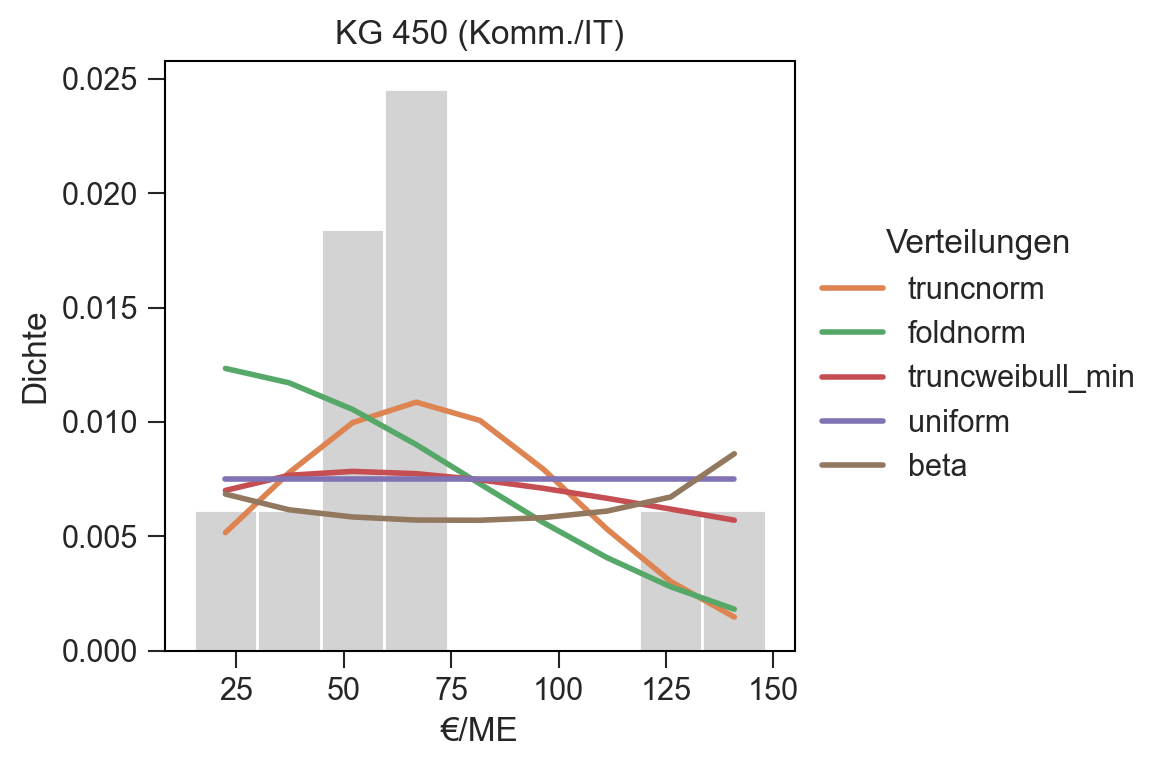

In [63]:
# prepare example data
example_data =  12 #4
data = phase2_raw[phase2_raw.columns[example_data]]
fit_data = data.dropna().values  # remove NaN

# fit distributions
f = Fitter(fit_data, distributions=distributions_to_fit, bins="auto")
f.fit()

# change figure size
fig = plt.figure(figsize=(6, 4))

f.summary()

# change appearance of histogram
ax = plt.gca()  # get current axes
for patch in ax.patches:
    patch.set_facecolor("lightgray")

# add title and axis labels
ax.set_title(labels_title[example_data]+" ("+labels_text[example_data]+")", fontsize=12)
ax.set_xlabel("€/ME", fontsize=12)
ax.set_ylabel("Dichte", fontsize=12)
ax.legend(
    title="Verteilungen",
    loc="center left",
    frameon=False,
    bbox_to_anchor=(1, 0.5)  # shift legend outside the axis
)
plt.tight_layout()  # avoids clipping

plt.show()


In [ ]:
# fitting distributions for each KG
# create a list to store results
results = []

for column in phase2_raw.columns:
    data = phase2_raw[column].dropna().values
    n = len(data)

    f = Fitter(data,
                distributions=distributions_to_fit,
                bins="auto")
    f.fit()

    best = f.get_best(method="sumsquare_error")
    best_dist = list(best.keys())[0]
    params = best[best_dist]
    sse = f.df_errors.loc[best_dist, "sumsquare_error"]

    results.append({
        "Feature": column,
        "Best Distribution": best_dist,
        "Parameters": params,
        "SSE": sse
    })
    
    print(f"Fitting {column} (n={n})... -> {best_dist}")


# convert results to dataframe
fit_results_df = pd.DataFrame(results)

# show selected columns
cols = ["Feature", "Best Distribution", "Parameters", "SSE"]
fit_results_df[cols]

Fitting kg_310_korrigiert_db (n=11)... -> foldnorm
Fitting kg_320_korrigiert_db (n=11)... -> truncnorm
Fitting kg_330_korrigiert_db (n=11)... -> truncnorm
Fitting kg_340_korrigiert_db (n=11)... -> truncnorm
Fitting kg_350_korrigiert_db (n=10)... -> truncnorm
Fitting kg_360_korrigiert_db (n=11)... -> foldnorm
Fitting kg_380_korrigiert_db (n=8)... -> beta
Fitting kg_390_korrigiert_db (n=11)... -> truncweibull_min
Fitting kg_410_korrigiert_db (n=11)... -> foldnorm
Fitting kg_420_korrigiert_db (n=11)... -> beta
Fitting kg_430_korrigiert_db (n=10)... -> foldnorm
Fitting kg_440_korrigiert_db (n=11)... -> truncweibull_min
Fitting kg_450_korrigiert_db (n=11)... -> truncnorm
Fitting kg_460_korrigiert_db (n=6)... -> beta
Fitting kg_470_korrigiert_db (n=4)... -> uniform
Fitting kg_480_korrigiert_db (n=6)... -> foldnorm
Fitting kg_490_korrigiert_db (n=3)... -> truncnorm
Fitting kg_500_korrigiert_db (n=8)... -> beta
Fitting kg_600_korrigiert_db (n=9)... -> foldnorm
Fitting kg_700_korrigiert_db_phas

Feature Best Distribution  \
0          kg_310_korrigiert_db          foldnorm   
1          kg_320_korrigiert_db         truncnorm   
2          kg_330_korrigiert_db         truncnorm   
3          kg_340_korrigiert_db         truncnorm   
4          kg_350_korrigiert_db         truncnorm   
5          kg_360_korrigiert_db          foldnorm   
6          kg_380_korrigiert_db              beta   
7          kg_390_korrigiert_db  truncweibull_min   
8          kg_410_korrigiert_db          foldnorm   
9          kg_420_korrigiert_db              beta   
10         kg_430_korrigiert_db          foldnorm   
11         kg_440_korrigiert_db  truncweibull_min   
12         kg_450_korrigiert_db         truncnorm   
13         kg_460_korrigiert_db              beta   
14         kg_470_korrigiert_db           uniform   
15         kg_480_korrigiert_db          foldnorm   
16         kg_490_korrigiert_db         truncnorm   
17         kg_500_korrigiert_db              beta   
18         kg_600_korrigiert_db          foldnorm   
19  kg_700_korrigiert_db_phase2          foldnorm   

                                           Parameters       SSE  
0   {'c': 0.3994332980743396, 'loc': 19.4471747416...  0.000067  
1   {'a': 297.9244934498216, 'b': 926.566936221044...  0.000001  
2   {'a': 479.47567835409455, 'b': 1412.5530035488...  0.000002  
3   {'a': -7058.370100568431, 'b': 36274.130914926...  0.000010  
4   {'a': 334.3101426493832, 'b': 685.529363230374...  0.000004  
5   {'c': 0.05240455541371429, 'loc': 306.05534812...  0.000001  
6   {'a': 0.6423290031021686, 'b': 0.7302923677446...  0.000326  
7   {'c': 1.1180306362635957, 'a': 1.2234013455459...  0.000010  
8   {'c': 5.83470797837114, 'loc': -38.35007693689...  0.000123  
9   {'a': 1.3311477719174163, 'b': 0.8352784906350...  0.000064  
10  {'c': 0.6202701496491545, 'loc': 9.41788978120...  0.000023  
11  {'c': 0.9031340094841531, 'a': 0.0015454846288...  0.000015  
12  {'a': -382.650634410487, 'b': 1376.77765943368...  0.000487  
13  {'a': 2.247805769757627, 'b': 0.58124029529451...  0.002554  
14  {'loc': 1.209637219606757, 'scale': 1.25725170...  0.948958  
15  {'c': 3.868965378939057e-05, 'loc': 10.5888030...  0.000194  
16  {'a': 0.7562973161582729, 'b': 24.972082750956...  0.005857  
17  {'a': 0.41792801778724775, 'b': 0.659323879678...  0.000004  
18  {'c': 0.12873162369632135, 'loc': 0.8816678807...  0.003690  
19  {'c': 0.7252375435123539, 'loc': 93.1055505002...  0.000234

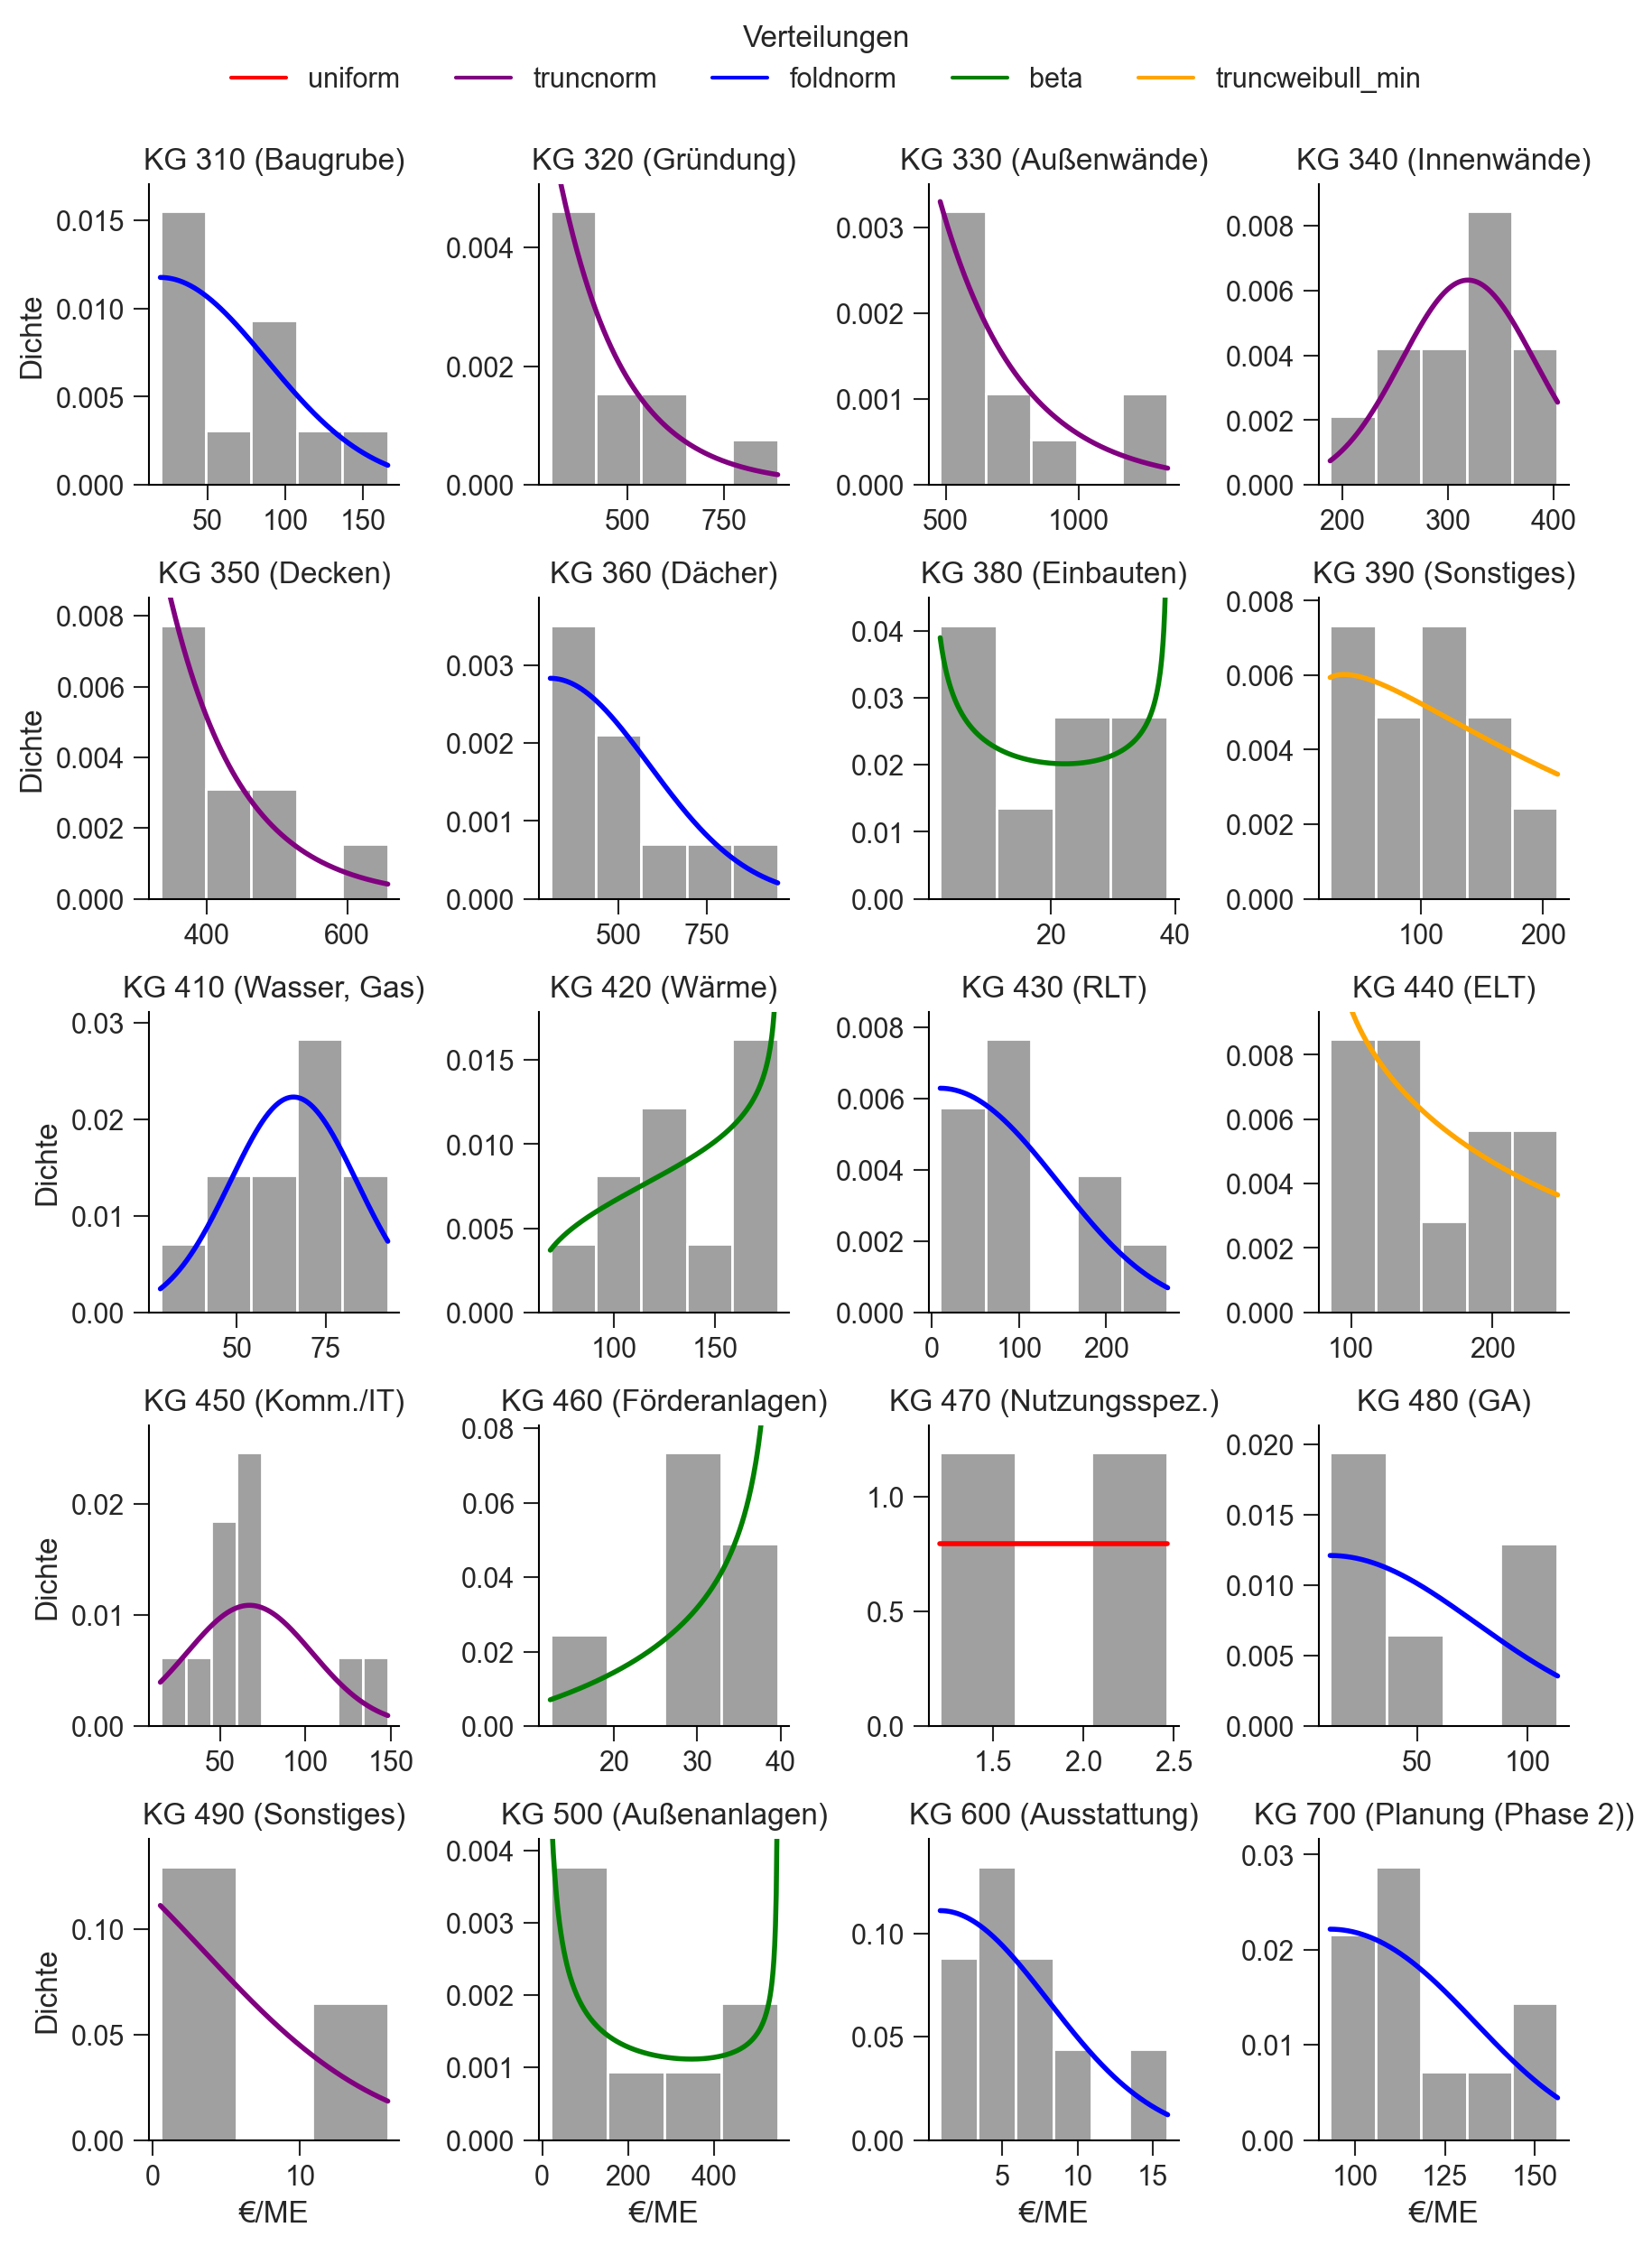

In [15]:
# melt original df for FacetGrid plotting
df_long = phase2_raw.melt(var_name="KG", value_name="€/ME")

# map feature name to its best fit and params
best_fits = {
    row["Feature"]: {"dist": row["Best Distribution"], "params": row["Parameters"]}
    for _, row in fit_results_df.iterrows()
}

# define plotting function for each subplot
def plot_hist_with_fit(data, **kwargs):
    feature = data["KG"].iloc[0]
    values = data["€/ME"].dropna()

    # plot histogram in gray
    sns.histplot(values, kde=False, stat="density", bins="auto", color="gray")

    # overlay best fit curve
    fit_info = best_fits.get(feature)
    if fit_info:
        dist_name = fit_info["dist"]
        param_dict = fit_info["params"]
        dist = getattr(stats, dist_name)

        # extract parameters in correct order: shape(s), loc, scale
        shape_keys = [k for k in param_dict.keys() if k not in ["loc", "scale"]]
        shape_params = [float(param_dict[k]) for k in shape_keys]
        loc = float(param_dict.get("loc", 0))
        scale = float(param_dict.get("scale", 1))

        x = np.linspace(values.min(), values.max(), 300)
        y = dist.pdf(x, *shape_params, loc=loc, scale=scale)

        plt.plot(x, y, color=colors[dist_name], lw=2, label=dist_name)

        # get max y-value of histogram bars (patches)
        hist_max = max(p.get_height() for p in plt.gca().patches)

        # set y-limit slightly above histogram max to keep bars visible
        plt.ylim(0, hist_max * 1.1)

# create FacetGrid
g = sns.FacetGrid(df_long, col="KG", col_wrap=4, height=2.5, aspect=0.9, sharex=False, sharey=False)
g.map_dataframe(plot_hist_with_fit)

# add a single legend for all plots
handles = [plt.Line2D([], [], color=col, label=dist) for dist, col in colors.items()]
g.figure.legend(handles=handles, loc="upper center", ncol=len(colors), title="Verteilungen", frameon=False)

# Set custom titles
for ax, title, text in zip(g.axes.flat, labels_title, labels_text):
    ax.set_title(title+" ("+text+")")

# Add data count and selective ylabel
for i, (ax, (kg, group)) in enumerate(zip(g.axes.flat, phase2_long.groupby("KG"))):

    # Only show 'Anzahl' on y-axis of leftmost column
    if i % g._ncol == 0:
        ax.set_ylabel("Dichte")
    else:
        ax.set_ylabel("")

    # Set x-axis label only on bottom row
    if i // g._ncol == g._nrow - 1:
        ax.set_xlabel("€/ME")
    else:
        ax.set_xlabel("")

# Improve layout
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

In [16]:
# list to store mcerp uncertainty variables
cost_distr = []

# loop over best-fitted results to retrieve random variables
for idx, row in fit_results_df.iterrows():
    dist_name = row["Best Distribution"]
    params = row["Parameters"]

    loc = params.get("loc", 0)
    scale = params.get("scale", 1)

    print(f"Constructing distribution {idx+1}/{len(fit_results_df)}...")

    if dist_name == "norm":
        rv = Normal(mu=loc, sigma=scale)

    elif dist_name == "uniform":
        min_val = loc
        max_val = loc + scale
        rv = Uniform(min_val, max_val)

    elif dist_name == "gamma":
        shape = params.get("a", 1)
        theta = scale
        rv = uv(stats.gamma(a=shape, loc=loc, scale=theta), tag=None)

    elif dist_name == "beta":
        alpha = params.get("a", 1)
        beta = params.get("b", 1)
        low = loc
        high = scale
        rv = Beta(alpha=alpha, beta=beta, low=low, high=high)

    elif dist_name == "truncnorm":
        a = params.get("a", -1)
        b = params.get("b", 1)
        rv = uv(stats.truncnorm(a=a, b=b, loc=loc, scale=scale), tag=None)
    
    elif dist_name == "weibull_min":
        c = params.get("c", 1)
        rv = uv(stats.weibull_min(c=c, loc=loc, scale=scale), tag=None)

    elif dist_name == "foldnorm":
        c = params.get("c", 1)
        rv = uv(stats.foldnorm(c=c, loc=loc, scale=scale), tag=None)

    elif dist_name == "fisk":
        c = params.get("c", 1)
        rv = uv(stats.fisk(c=c, loc=loc, scale=scale), tag=None)

    elif dist_name == "genlogistic":
        c = params.get("c", 1)
        rv = uv(stats.genlogistic(c=c, loc=loc, scale=scale), tag=None)

    elif dist_name == "triang":
        c = params.get("c", 0.5)  # mode as fraction of scale
        low = loc
        high = loc + scale
        # 0ptional: clamp c to [0,1] just in case
        c = min(max(c, 0), 1)
        rv = uv(stats.triang(c=c, loc=low, scale=high - low), tag=None)
    
    elif dist_name == "truncweibull_min":
        a = params.get("a", 1)  # truncation shape
        b = params.get("b", 1)
        c = params.get("c", 1)  # Weibull shape      
        rv = uv(stats.truncweibull_min(a=a, b=b, c=c, loc=loc, scale=scale), tag=None)

    print(f"-> ...{dist_name} succesfully created!")
    
    cost_distr.append(rv)
cost_distr

# check type
for i in range(len(cost_distr)):
    print(i, phase2_raw.columns[i], fit_results_df["Best Distribution"].iloc[i], type(cost_distr[i]))

Constructing distribution 1/20...
-> ...foldnorm succesfully created!
Constructing distribution 2/20...
-> ...truncnorm succesfully created!
Constructing distribution 3/20...
-> ...truncnorm succesfully created!
Constructing distribution 4/20...
-> ...truncnorm succesfully created!
Constructing distribution 5/20...
-> ...truncnorm succesfully created!
Constructing distribution 6/20...
-> ...foldnorm succesfully created!
Constructing distribution 7/20...
-> ...beta succesfully created!
Constructing distribution 8/20...
-> ...truncweibull_min succesfully created!
Constructing distribution 9/20...
-> ...foldnorm succesfully created!
Constructing distribution 10/20...
-> ...beta succesfully created!
Constructing distribution 11/20...
-> ...foldnorm succesfully created!
Constructing distribution 12/20...
-> ...truncweibull_min succesfully created!
Constructing distribution 13/20...
-> ...truncnorm succesfully created!
Constructing distribution 14/20...
-> ...beta succesfully created!
Constr

In [17]:
# function to create uncertain variables (alternative)
# def create_uv_from_fit(dist_name, params):
#     # Handle default location and scale
#     loc = params.get("loc", 0)
#     scale = params.get("scale", 1)

#     # Build args tuple from all shape parameters (excluding loc/scale)
#     shape_keys = [k for k in params.keys() if k not in ["loc", "scale"]]
#     shape_args = tuple(params[k] for k in shape_keys)

#     print(f"Creating {dist_name} distribution...")

#     try:
#         # Get the scipy.stats distribution
#         dist = getattr(stats, dist_name)

#         # Create frozen distribution
#         frozen = dist(*shape_args, loc=loc, scale=scale)

#         # Wrap in mcerp uncertainty variable
#         print(f"-> ...{dist_name} succesfully created!")
#         return uv(frozen, tag=None)
#     except AttributeError:
#         raise ValueError(f"Distribution '{dist_name}' not found in scipy.stats")
#     except Exception as e:
#         raise RuntimeError(f"Failed to create distribution '{dist_name}': {e}")

# cost_distr = []

# for idx, row in fit_results_df.iterrows():
#     dist_name = row["Best Distribution"]
#     params = row["Parameters"]

#     rv = create_uv_from_fit(dist_name, params)
#     cost_distr.append(rv)

# # check type
# for i in range(len(cost_distr)):
#     print(i, phase2_raw.columns[i], fit_results_df["Best Distribution"].iloc[i], type(cost_distr[i]))

In [18]:
# comparison of simulated random variables vs raw data input
# select variable
sel_col = 5

df1 = phase2_raw[phase2_raw.columns[sel_col]].describe()
df2 = pd.DataFrame(cost_distr[sel_col]._mcpts).describe()
pd.concat([df1, df2], axis=1).reindex(df1.index)

kg_360_korrigiert_db             0
count             11.000000  50000.000000
mean             519.068078    530.737333
std              193.129357    169.745859
min              306.055348    306.056690
25%              388.666186    395.787048
50%              446.966233    495.989209
75%              582.235437    629.993669
max              952.566393   1513.153589

<Axes: ylabel='Count'>

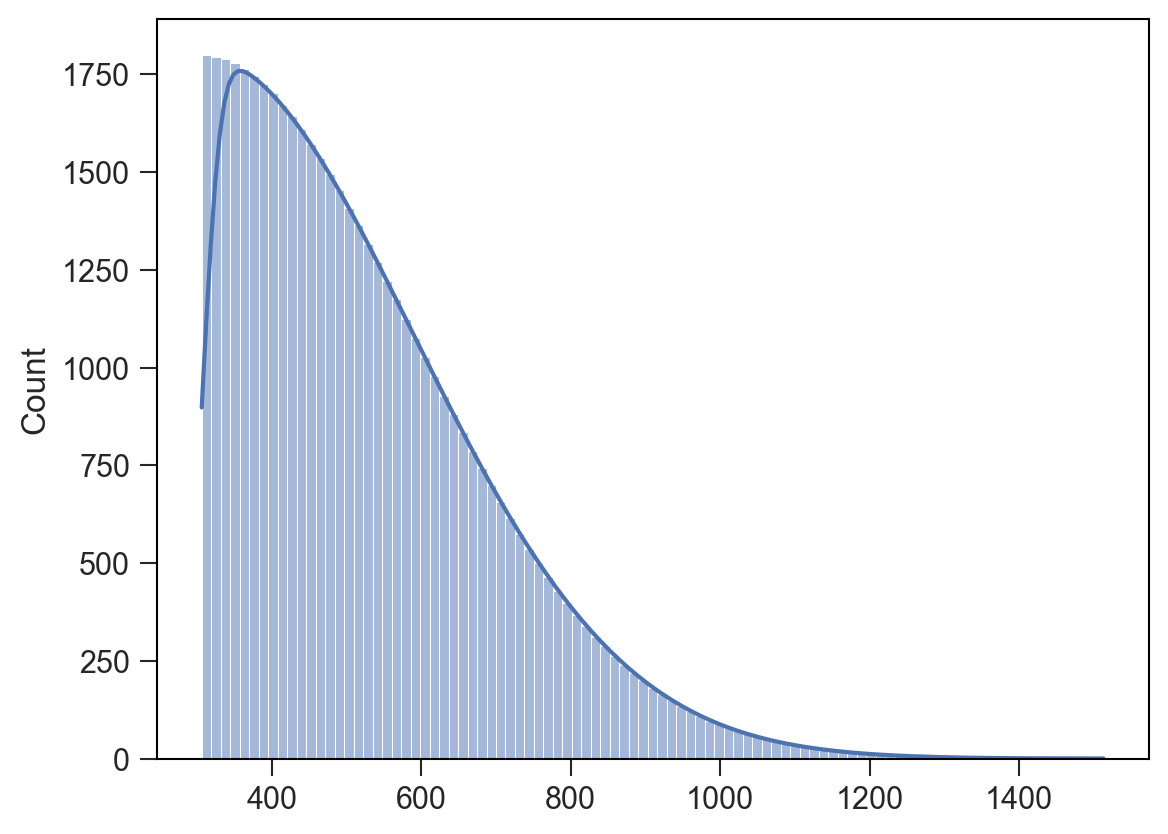

In [19]:
# plot selected distributions
sns.histplot(data=cost_distr[sel_col]._mcpts, kde=True)


## Korrelation

In [20]:
# compute the correlation matrix (ignoring NaNs)
corr_matrix = phase2_raw.corr(method="pearson")

corr_matrix

kg_310_korrigiert_db  kg_320_korrigiert_db  \
kg_310_korrigiert_db                     1.000000             -0.039743   
kg_320_korrigiert_db                    -0.039743              1.000000   
kg_330_korrigiert_db                     0.561431             -0.075098   
kg_340_korrigiert_db                     0.203362             -0.036933   
kg_350_korrigiert_db                     0.159086              0.089869   
kg_360_korrigiert_db                     0.501209             -0.003586   
kg_380_korrigiert_db                     0.444475             -0.376090   
kg_390_korrigiert_db                     0.589154             -0.230983   
kg_410_korrigiert_db                    -0.557925              0.139436   
kg_420_korrigiert_db                    -0.173996             -0.276541   
kg_430_korrigiert_db                     0.127209              0.191010   
kg_440_korrigiert_db                    -0.181799             -0.290167   
kg_450_korrigiert_db                    -0.394298              0.757130   
kg_460_korrigiert_db                    -0.613623              0.385876   
kg_470_korrigiert_db                     0.135866              0.604034   
kg_480_korrigiert_db                     0.489572             -0.121216   
kg_490_korrigiert_db                    -0.107682             -0.998742   
kg_500_korrigiert_db                     0.292686             -0.493418   
kg_600_korrigiert_db                    -0.370617              0.667657   
kg_700_korrigiert_db_phase2              0.226079              0.235527   

                             kg_330_korrigiert_db  kg_340_korrigiert_db  \
kg_310_korrigiert_db                     0.561431              0.203362   
kg_320_korrigiert_db                    -0.075098             -0.036933   
kg_330_korrigiert_db                     1.000000              0.554801   
kg_340_korrigiert_db                     0.554801              1.000000   
kg_350_korrigiert_db                     0.382854              0.175594   
kg_360_korrigiert_db                     0.841781              0.589766   
kg_380_korrigiert_db                     0.196017              0.460861   
kg_390_korrigiert_db                     0.811090              0.259302   
kg_410_korrigiert_db                    -0.184503             -0.245073   
kg_420_korrigiert_db                    -0.087220             -0.433961   
kg_430_korrigiert_db                     0.536651              0.521815   
kg_440_korrigiert_db                     0.228878              0.305590   
kg_450_korrigiert_db                    -0.146886              0.075277   
kg_460_korrigiert_db                     0.067964             -0.298602   
kg_470_korrigiert_db                     0.132271              0.464340   
kg_480_korrigiert_db                     0.952240              0.203246   
kg_490_korrigiert_db                    -0.431885              0.990118   
kg_500_korrigiert_db                     0.562137              0.037633   
kg_600_korrigiert_db                    -0.445240              0.099355   
kg_700_korrigiert_db_phase2              0.706950              0.403878   

                             kg_350_korrigiert_db  kg_360_korrigiert_db  \
kg_310_korrigiert_db                     0.159086              0.501209   
kg_320_korrigiert_db                     0.089869             -0.003586   
kg_330_korrigiert_db                     0.382854              0.841781   
kg_340_korrigiert_db                     0.175594              0.589766   
kg_350_korrigiert_db                     1.000000              0.691361   
kg_360_korrigiert_db                     0.691361              1.000000   
kg_380_korrigiert_db                     0.622297              0.550412   
kg_390_korrigiert_db                     0.337702              0.642324   
kg_410_korrigiert_db                     0.231402             -0.124427   
kg_420_korrigiert_db                    -0.272883             -0.107189   
kg_430_korrigiert_db                     0.691400   

In [21]:
# helper function for heatmaps
def corr_heatmap(matrix, cmap, tick_labels):
    # size
    plt.figure(figsize=(20,20))

    # generate a mask for the upper triangle
    mask = np.triu(np.ones_like(matrix, dtype=bool))

    # plot
    sns.heatmap(matrix, mask=mask, cmap=cmap, vmax=1, center=0, 
                square=True, linewidths=.5, annot=matrix.round(3), 
                xticklabels=tick_labels, yticklabels=tick_labels,
                cbar_kws={"shrink": .5})

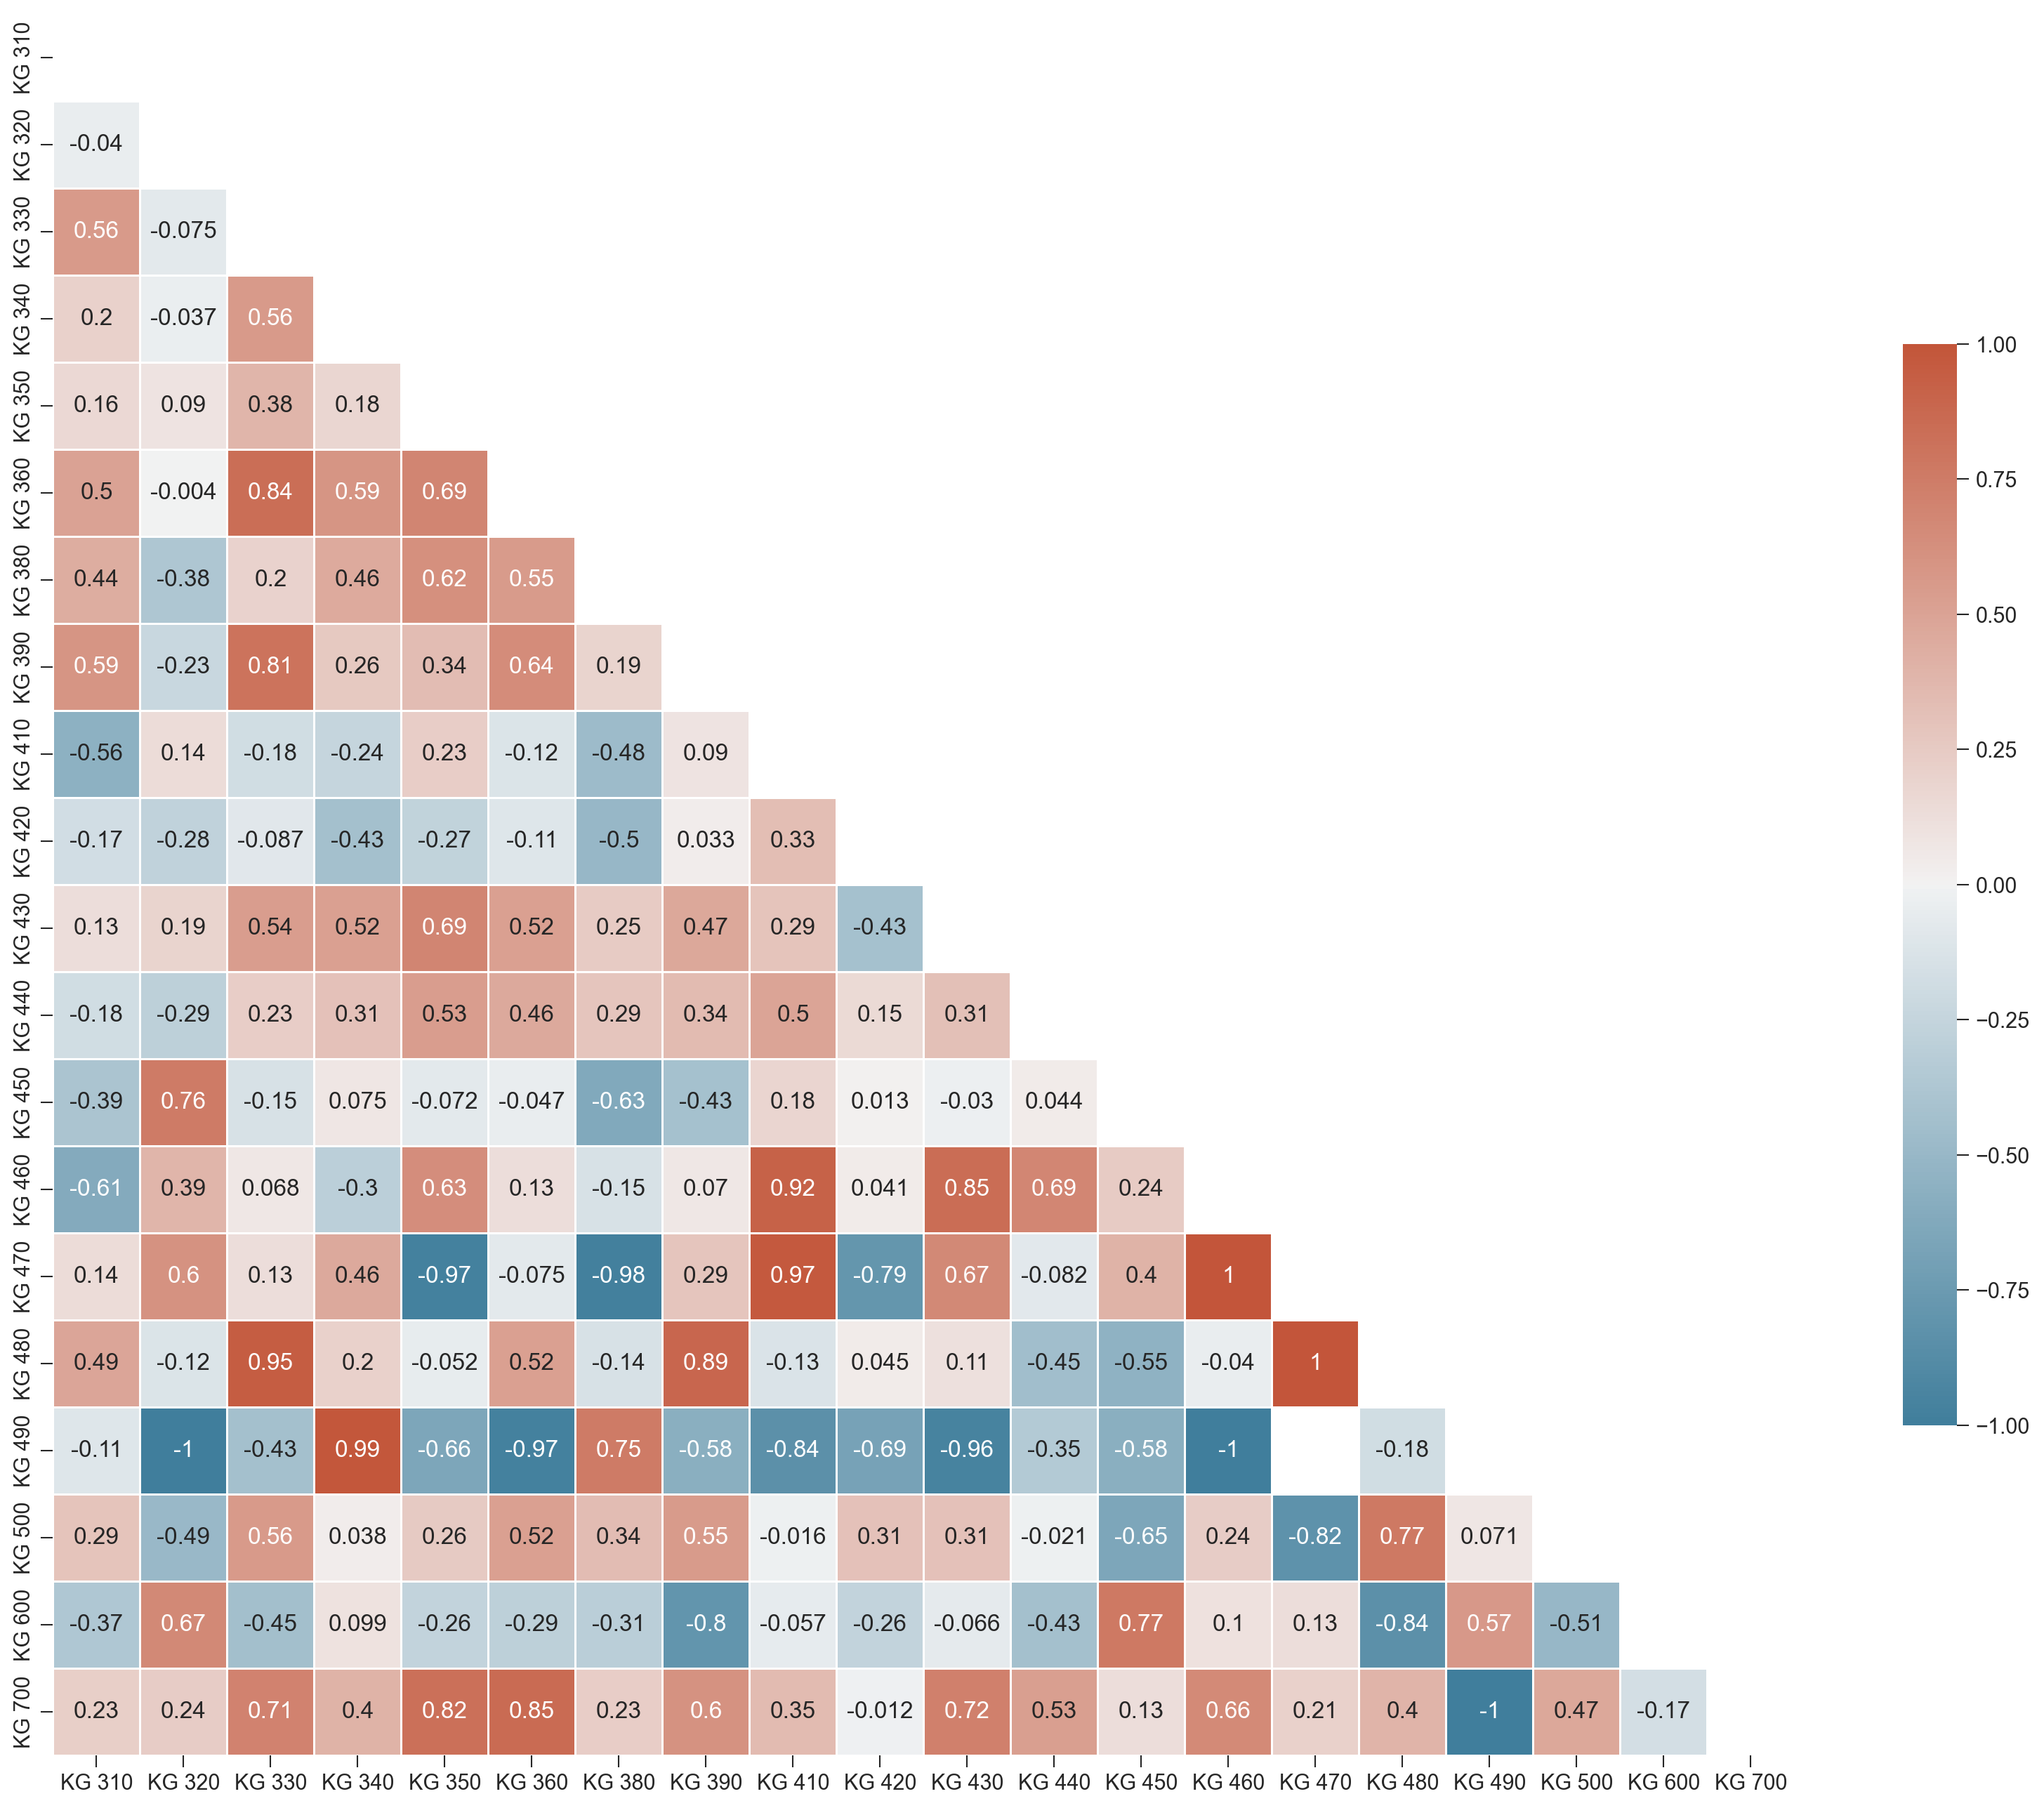

In [22]:
# plot correlation matrix
cmap = sns.diverging_palette(230, 20, as_cmap=True)

corr_heatmap(corr_matrix,cmap,labels_title)

In [23]:
# calculate p-values for significance test
cols = phase2_raw.columns
n = len(cols)

# empty DataFrames for p-values
p_matrix = pd.DataFrame(np.nan, index=cols, columns=cols)

# pairwise pearsonr for all combinations
for i in range(n):
    for j in range(i, n):
        x = phase2_raw[cols[i]]
        y = phase2_raw[cols[j]]
        
        # only pairs without NaN
        valid = x.notna() & y.notna()
        x_valid = x[valid]
        y_valid = y[valid]
        
        if len(x_valid) > 2:  # minimum 3 values for pearsonr
            r, p = pearsonr(x_valid, y_valid)
            corr_matrix.iat[i, j] = r
            corr_matrix.iat[j, i] = r  # symmetric
            p_matrix.iat[i, j] = p
            p_matrix.iat[j, i] = p
        else:
            corr_matrix.iat[i, j] = np.nan
            corr_matrix.iat[j, i] = np.nan
            p_matrix.iat[i, j] = np.nan
            p_matrix.iat[j, i] = np.nan

print("\nP-Wert-Matrix:")
p_matrix


P-Wert-Matrix:


kg_310_korrigiert_db  kg_320_korrigiert_db  \
kg_310_korrigiert_db                     0.000000              0.907641   
kg_320_korrigiert_db                     0.907641              0.000000   
kg_330_korrigiert_db                     0.072308              0.826303   
kg_340_korrigiert_db                     0.548678              0.914150   
kg_350_korrigiert_db                     0.660674              0.804991   
kg_360_korrigiert_db                     0.116282              0.991651   
kg_380_korrigiert_db                     0.269866              0.358504   
kg_390_korrigiert_db                     0.056489              0.494384   
kg_410_korrigiert_db                     0.074499              0.682621   
kg_420_korrigiert_db                     0.608887              0.410394   
kg_430_korrigiert_db                     0.726190              0.597080   
kg_440_korrigiert_db                     0.592655              0.386726   
kg_450_korrigiert_db                     0.230149              0.006972   
kg_460_korrigiert_db                     0.195091              0.449915   
kg_470_korrigiert_db                     0.864134              0.395966   
kg_480_korrigiert_db                     0.324312              0.819066   
kg_490_korrigiert_db                     0.931315              0.031934   
kg_500_korrigiert_db                     0.481750              0.214034   
kg_600_korrigiert_db                     0.326155              0.049404   
kg_700_korrigiert_db_phase2              0.503847              0.485686   

                             kg_330_korrigiert_db  kg_340_korrigiert_db  \
kg_310_korrigiert_db                     0.072308              0.548678   
kg_320_korrigiert_db                     0.826303              0.914150   
kg_330_korrigiert_db                     0.000000              0.076488   
kg_340_korrigiert_db                     0.076488              0.000000   
kg_350_korrigiert_db                     0.274845              0.627513   
kg_360_korrigiert_db                     0.001155              0.056169   
kg_380_korrigiert_db                     0.641773              0.250443   
kg_390_korrigiert_db                     0.002448              0.441317   
kg_410_korrigiert_db                     0.587068              0.467638   
kg_420_korrigiert_db                     0.798725              0.182348   
kg_430_korrigiert_db                     0.109746              0.121855   
kg_440_korrigiert_db                     0.498436              0.360788   
kg_450_korrigiert_db                     0.666488              0.825893   
kg_460_korrigiert_db                     0.898211              0.565409   
kg_470_korrigiert_db                     0.867729              0.535660   
kg_480_korrigiert_db                     0.003367              0.699329   
kg_490_korrigiert_db                     0.715697              0.089574   
kg_500_korrigiert_db                     0.146987              0.929505   
kg_600_korrigiert_db                     0.229761              0.799253   
kg_700_korrigiert_db_phase2              0.014989              0.217996   

                             kg_350_korrigiert_db  kg_360_korrigiert_db  \
kg_310_korrigiert_db                     0.660674              0.116282   
kg_320_korrigiert_db                     0.804991              0.991651   
kg_330_korrigiert_db                     0.274845              0.001155   
kg_340_korrigiert_db                     0.627513              0.056169   
kg_350_korrigiert_db                     0.000000              0.026803   
kg_360_korrigiert_db                     0.026803              0.000000   
kg_380_korrigiert_db                     0.099430              0.157470   
kg_390_korrigiert_db                     0.339914              0.033082   
kg_410_korrigiert_db                     0.520053              0.715481   
kg_420_korrigiert_db                     0.445568              0.753759   
kg_430_korrigiert_db                     0.039121   

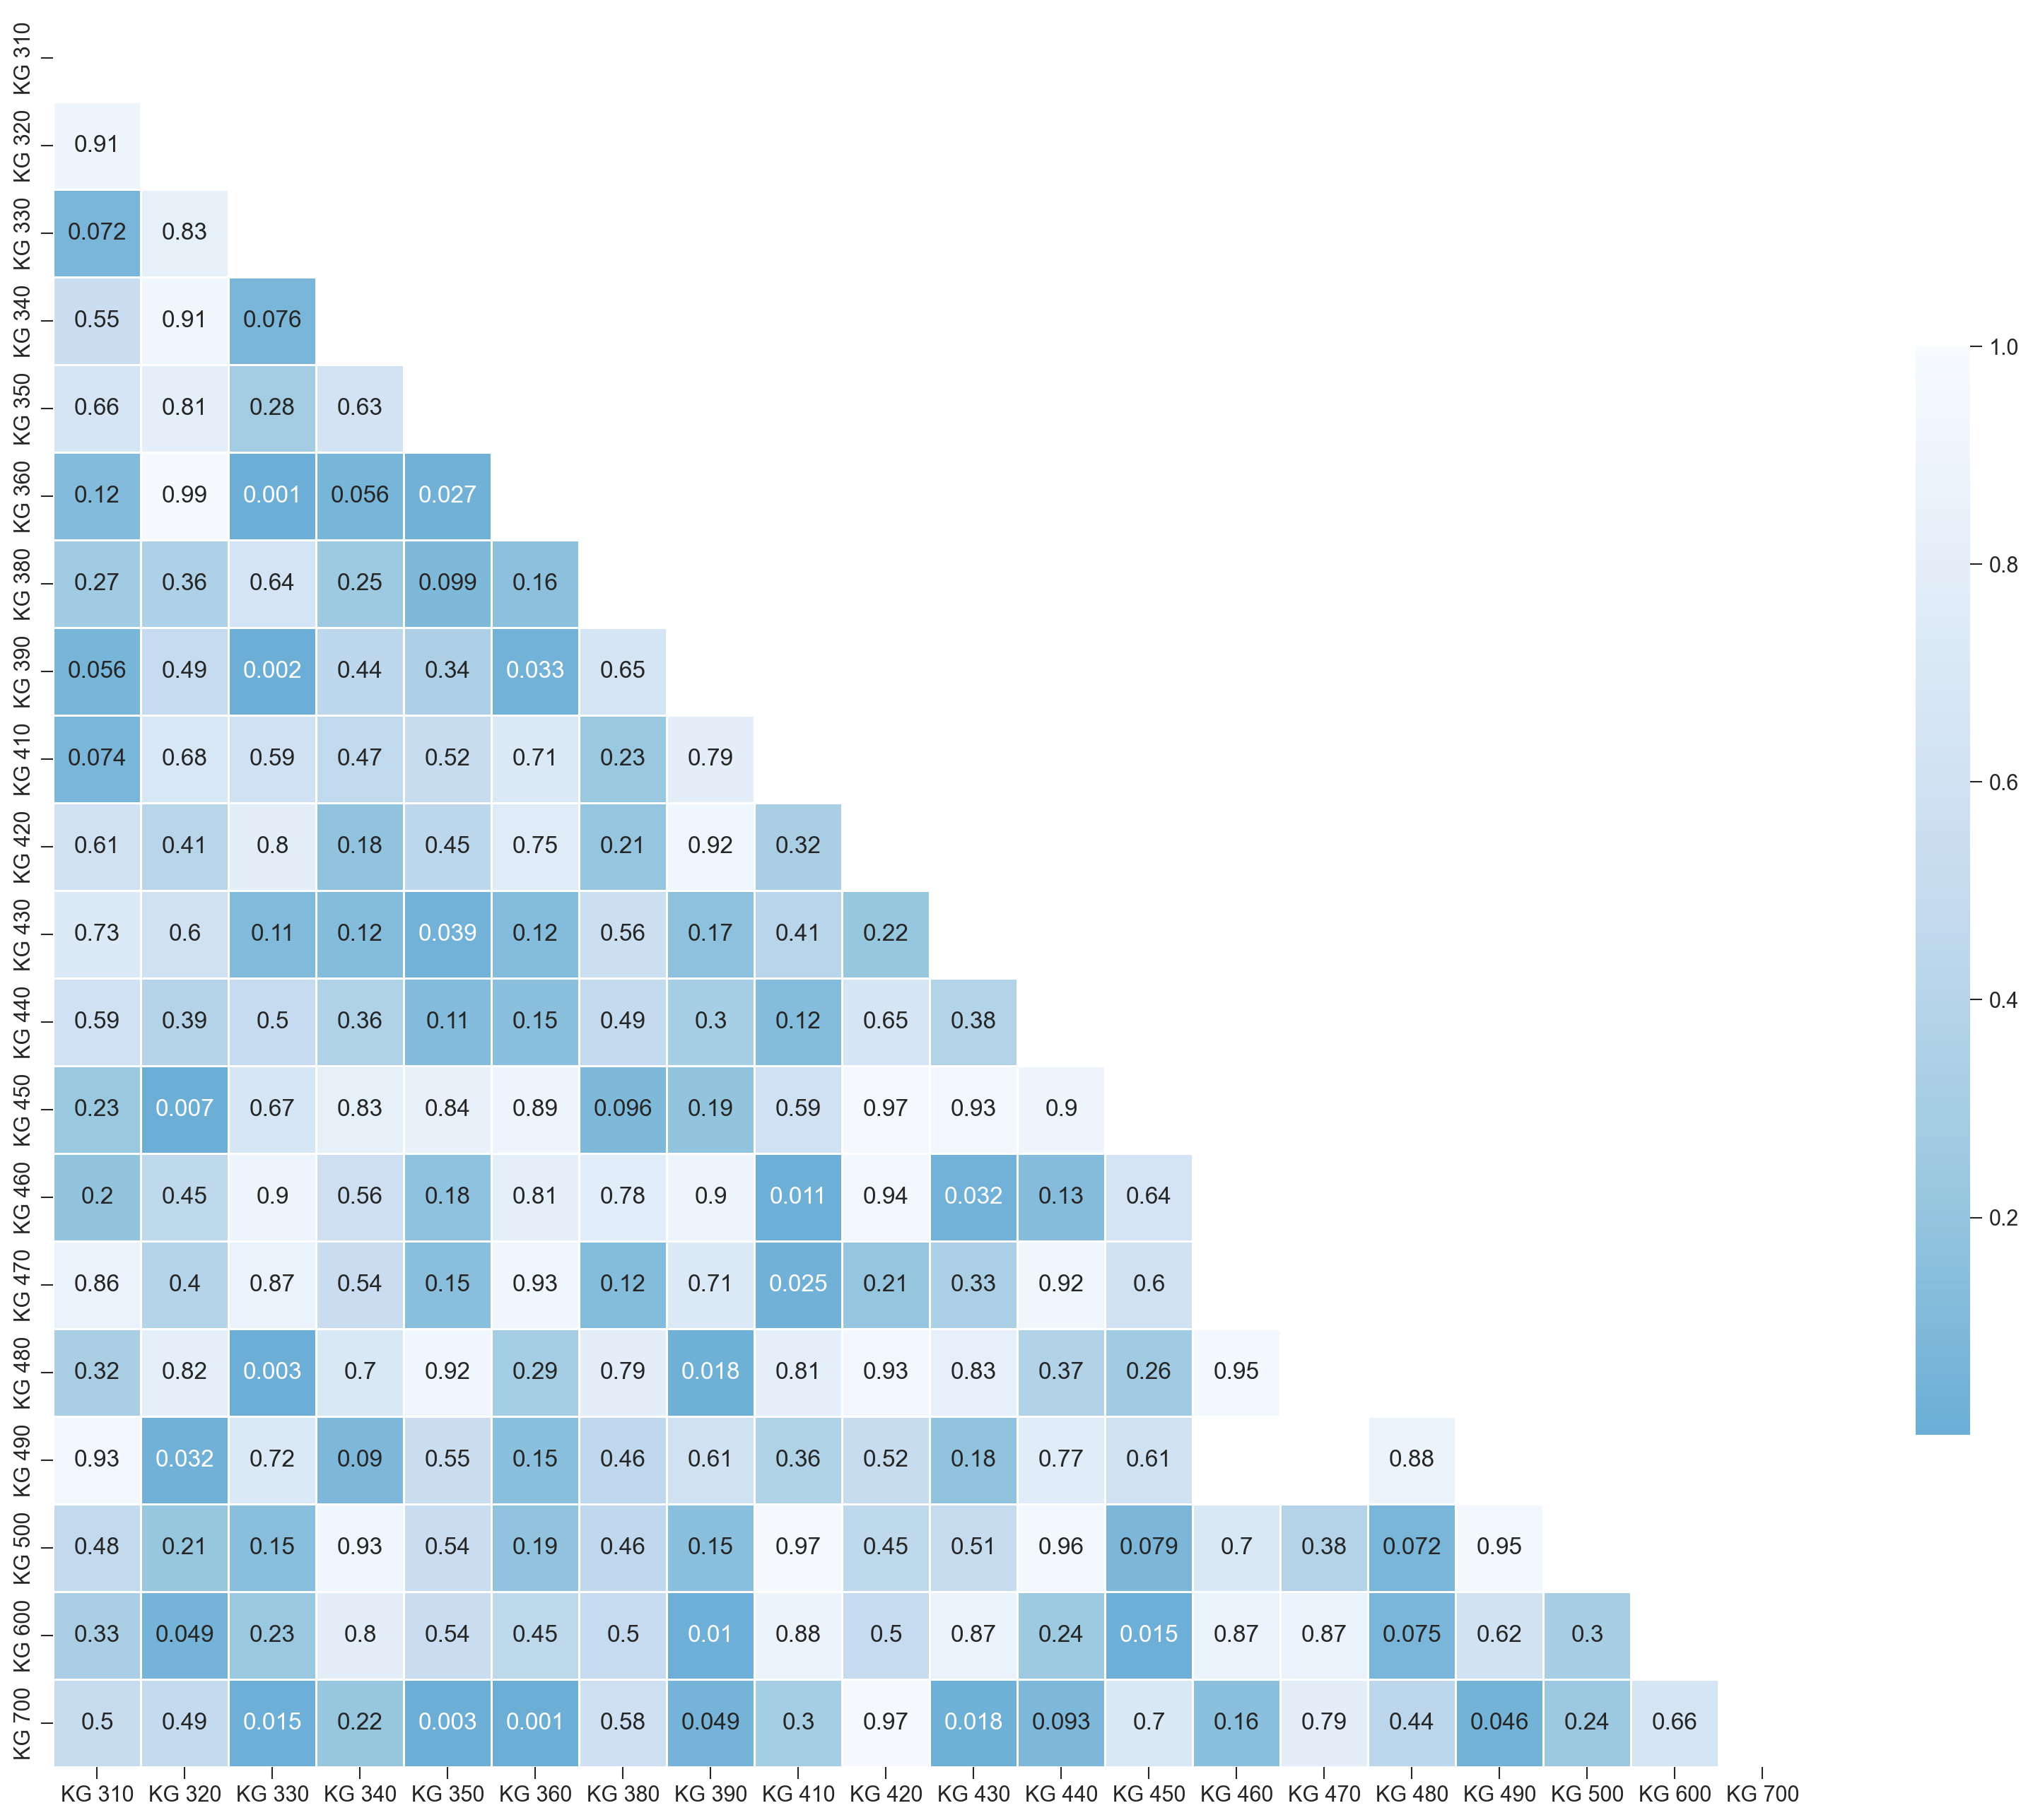

In [24]:
# plot p value matrix
cmap = sns.color_palette("Blues_r", as_cmap=True)

corr_heatmap(p_matrix,cmap,labels_title)


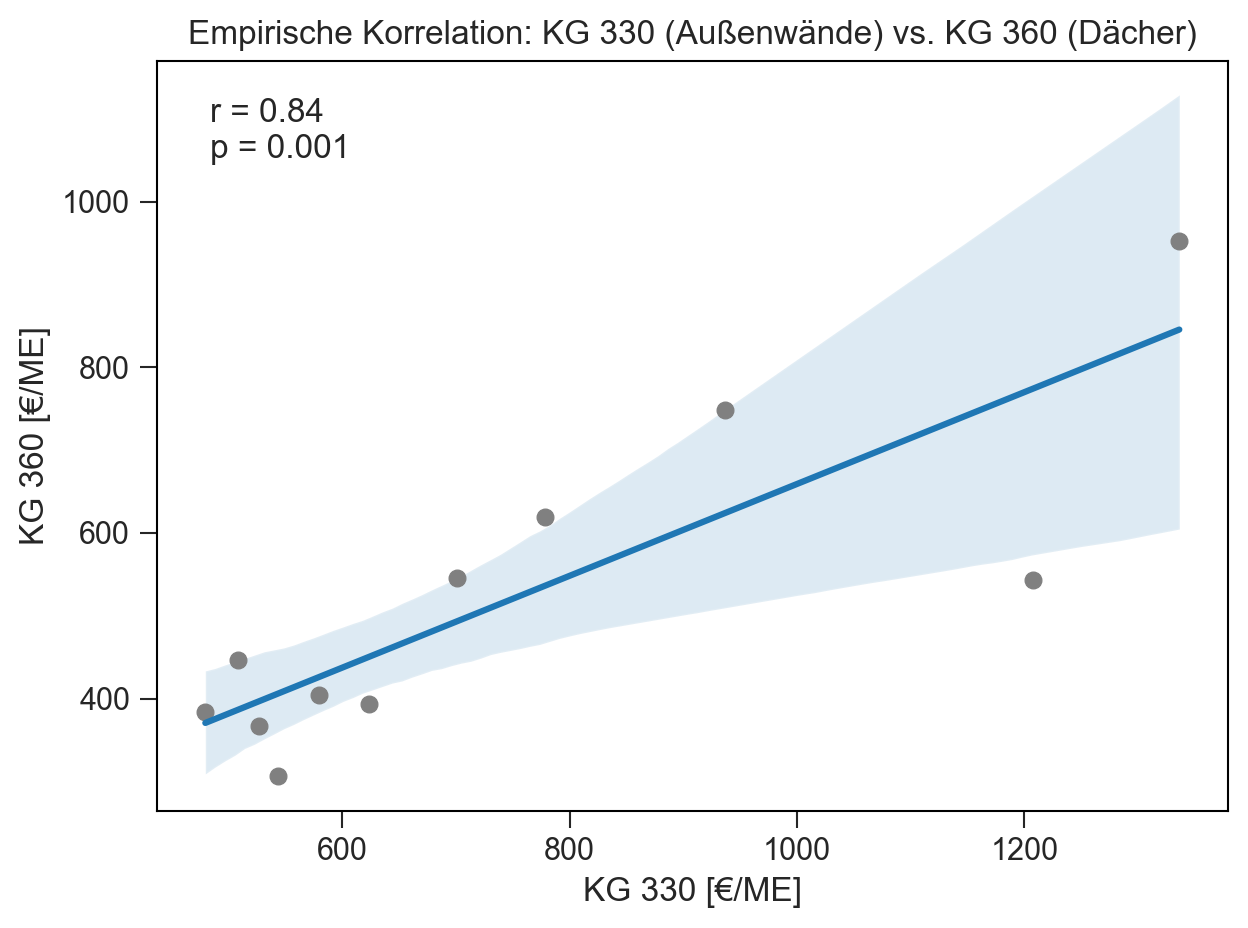

In [64]:
# correlation example
x_col = 2 #11
y_col = 5 #17

# drop rows with NaNs in either column
corr_plot = phase2_raw[[phase2_raw.columns[x_col], phase2_raw.columns[y_col]]].dropna()

# plot with regression line
sns.regplot(x=phase2_raw.columns[x_col], y=phase2_raw.columns[y_col], data=corr_plot, scatter=False, line_kws={"color": "tab:blue"})
sns.scatterplot(x=phase2_raw.columns[x_col], y=phase2_raw.columns[y_col], data=corr_plot, alpha=1, color="gray", edgecolor="gray")

# title and labels
plt.title(f"Empirische Korrelation: {labels_title[x_col]} ({labels_text[x_col]}) vs. {labels_title[y_col]} ({labels_text[y_col]})")
plt.xlabel(labels_title[x_col] + " [€/ME]")
plt.ylabel(labels_title[y_col] + " [€/ME]")

# extract r and p from correlation and p-value matrices
r = corr_matrix.iloc[x_col, y_col]
p = p_matrix.iloc[x_col, y_col]

# add r and p in upper left corner of the plot
plt.text(
    0.05, 0.95,
    f"r = {r:.2f}\np = {p:.3f}",
    transform=plt.gca().transAxes,
    ha='left', va='top',
    fontsize=12
)

plt.tight_layout()
plt.show()

In [26]:
# test significance
alpha = 0.01  # significance level

# create a copy of the correlation matrix
significant_corr = corr_matrix.copy()

# set correlation values to NaN where p-value is greater than alpha (not significant)
significant_corr[p_matrix > alpha] = np.nan

# replace NaN with 0 for non-significant correlations
significant_matrix = significant_corr.fillna(0).values

pd.DataFrame(significant_matrix)

0        1         2    3        4         5    6        7    8    9   \
0   1.0  0.00000  0.000000  0.0  0.00000  0.000000  0.0  0.00000  0.0  0.0   
1   0.0  1.00000  0.000000  0.0  0.00000  0.000000  0.0  0.00000  0.0  0.0   
2   0.0  0.00000  1.000000  0.0  0.00000  0.841781  0.0  0.81109  0.0  0.0   
3   0.0  0.00000  0.000000  1.0  0.00000  0.000000  0.0  0.00000  0.0  0.0   
4   0.0  0.00000  0.000000  0.0  1.00000  0.000000  0.0  0.00000  0.0  0.0   
5   0.0  0.00000  0.841781  0.0  0.00000  1.000000  0.0  0.00000  0.0  0.0   
6   0.0  0.00000  0.000000  0.0  0.00000  0.000000  1.0  0.00000  0.0  0.0   
7   0.0  0.00000  0.811090  0.0  0.00000  0.000000  0.0  1.00000  0.0  0.0   
8   0.0  0.00000  0.000000  0.0  0.00000  0.000000  0.0  0.00000  1.0  0.0   
9   0.0  0.00000  0.000000  0.0  0.00000  0.000000  0.0  0.00000  0.0  1.0   
10  0.0  0.00000  0.000000  0.0  0.00000  0.000000  0.0  0.00000  0.0  0.0   
11  0.0  0.00000  0.000000  0.0  0.00000  0.000000  0.0  0.00000  0.0  0.0   
12  0.0  0.75713  0.000000  0.0  0.00000  0.000000  0.0  0.00000  0.0  0.0   
13  0.0  0.00000  0.000000  0.0  0.00000  0.000000  0.0  0.00000  0.0  0.0   
14  0.0  0.00000  0.000000  0.0  0.00000  0.000000  0.0  0.00000  0.0  0.0   
15  0.0  0.00000  0.952240  0.0  0.00000  0.000000  0.0  0.00000  0.0  0.0   
16  0.0  0.00000  0.000000  0.0  0.00000  0.000000  0.0  0.00000  0.0  0.0   
17  0.0  0.00000  0.000000  0.0  0.00000  0.000000  0.0  0.00000  0.0  0.0   
18  0.0  0.00000  0.000000  0.0  0.00000  0.000000  0.0  0.00000  0.0  0.0   
19  0.0  0.00000  0.000000  0.0  0.82234  0.854513  0.0  0.00000  0.0  0.0   

     10   11       12   13   14       15   16   17   18        19  
0   0.0  0.0  0.00000  0.0  0.0  0.00000  0.0  0.0  0.0  0.000000  
1   0.0  0.0  0.75713  0.0  0.0  0.00000  0.0  0.0  0.0  0.000000  
2   0.0  0.0  0.00000  0.0  0.0  0.95224  0.0  0.0  0.0  0.000000  
3   0.0  0.0  0.00000  0.0  0.0  0.00000  0.0  0.0  0.0  0.000000  
4   0.0  0.0  0.00000  0.0  0.0  0.00000  0.0  0.0  0.0  0.822340  
5   0.0  0.0  0.00000  0.0  0.0  0.00000  0.0  0.0  0.0  0.854513  
6   0.0  0.0  0.00000  0.0  0.0  0.00000  0.0  0.0  0.0  0.000000  
7   0.0  0.0  0.00000  0.0  0.0  0.00000  0.0  0.0  0.0  0.000000  
8   0.0  0.0  0.00000  0.0  0.0  0.00000  0.0  0.0  0.0  0.000000  
9   0.0  0.0  0.00000  0.0  0.0  0.00000  0.0  0.0  0.0  0.000000  
10  1.0  0.0  0.00000  0.0  0.0  0.00000  0.0  0.0  0.0  0.000000  
11  0.0  1.0  0.00000  0.0  0.0  0.00000  0.0  0.0  0.0  0.000000  
12  0.0  0.0  1.00000  0.0  0.0  0.00000  0.0  0.0  0.0  0.000000  
13  0.0  0.0  0.00000  1.0  0.0  0.00000  0.0  0.0  0.0  0.000000  
14  0.0  0.0  0.00000  0.0  1.0  0.00000  0.0  0.0  0.0  0.000000  
15  0.0  0.0  0.00000  0.0  0.0  1.00000  0.0  0.0  0.0  0.000000  
16  0.0  0.0  0.00000  0.0  0.0  0.00000  1.0  0.0  0.0  0.000000  
17  0.0  0.0  0.00000  0.0  0.0  0.00000  0.0  1.0  0.0  0.000000  
18  0.0  0.0  0.00000  0.0  0.0  0.00000  0.0  0.0  1.0  0.000000  
19  0.0  0.0  0.00000  0.0  0.0  0.00000  0.0  0.0  0.0  1.000000

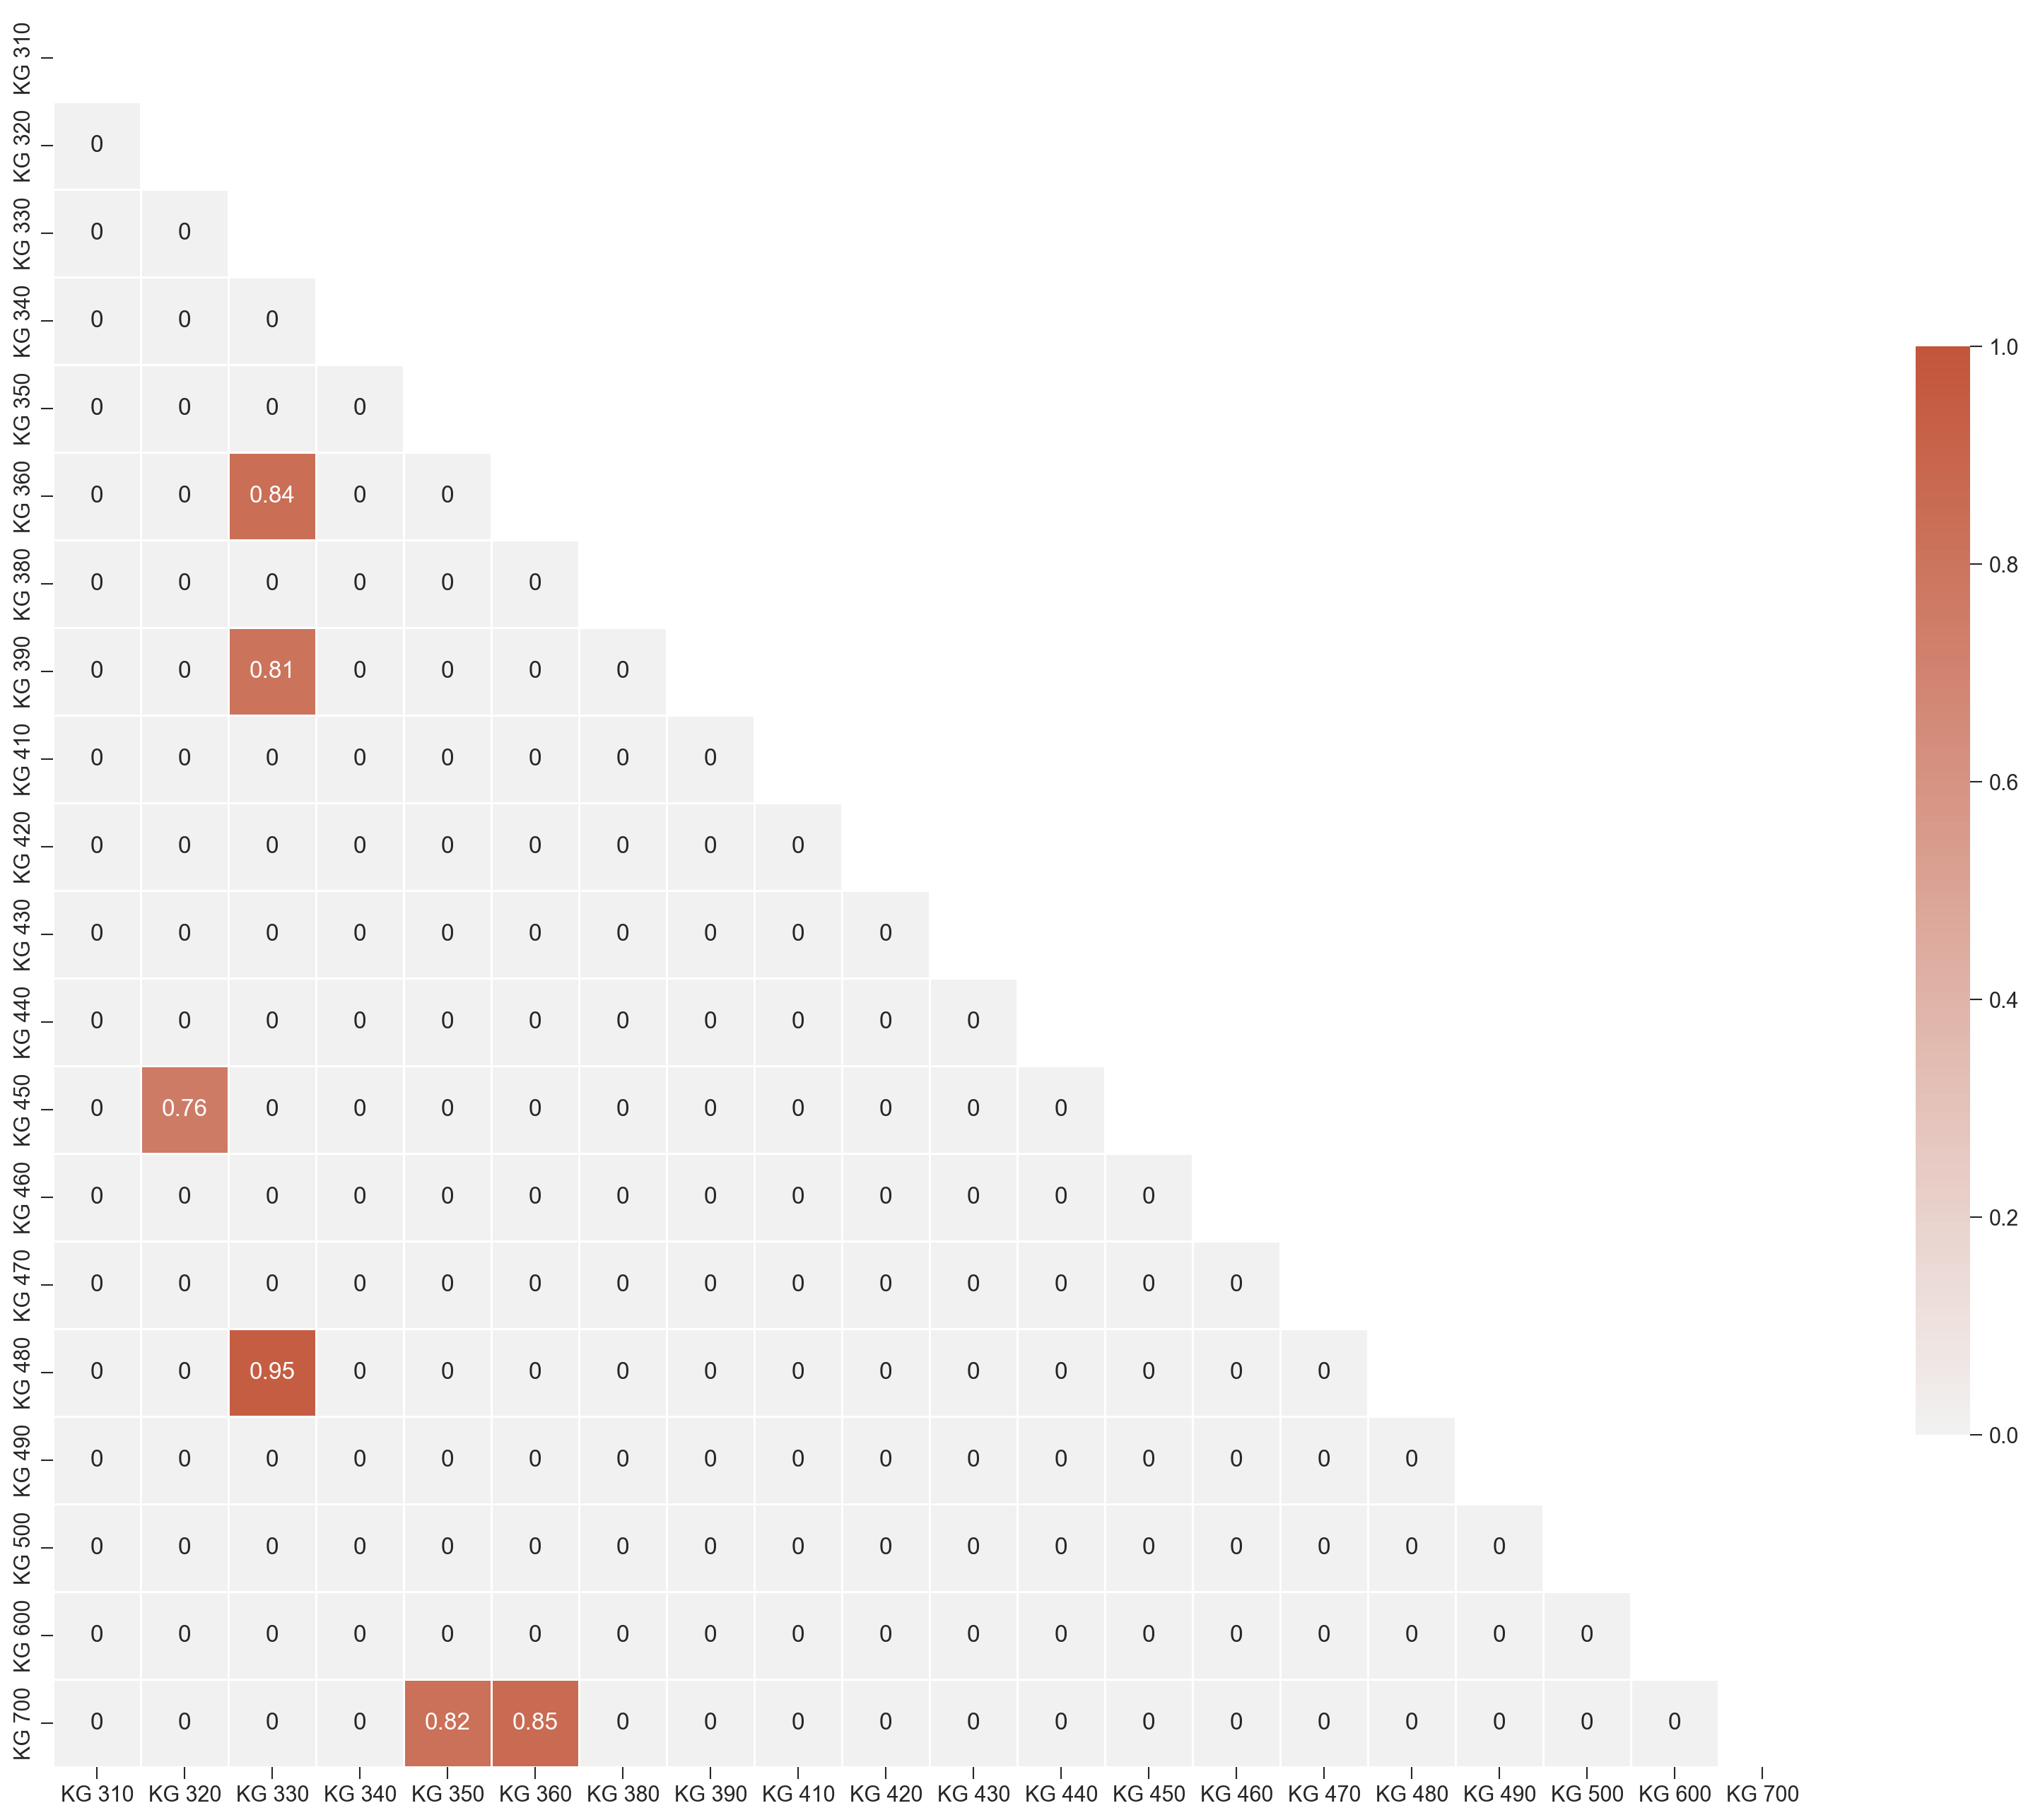

In [27]:
# plot significant correlation matrix
cmap = sns.diverging_palette(230, 20, as_cmap=True)

corr_heatmap(significant_matrix,cmap,labels_title)

In [28]:
def nearestPD(A):
    """Find the nearest positive-definite matrix to input

    A Python/Numpy port of John D'Errico's `nearestSPD` MATLAB code [1], which
    credits [2].

    [1] https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd

    [2] N.J. Higham, "Computing a nearest symmetric positive semidefinite
    matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6
    """

    B = (A + A.T) / 2
    _, s, V = la.svd(B)

    H = np.dot(V.T, np.dot(np.diag(s), V))

    A2 = (B + H) / 2

    A3 = (A2 + A2.T) / 2

    if isPD(A3):
        return A3

    spacing = np.spacing(la.norm(A))
    # The above is different from [1]. It appears that MATLAB's `chol` Cholesky
    # decomposition will accept matrixes with exactly 0-eigenvalue, whereas
    # Numpy's will not. So where [1] uses `eps(mineig)` (where `eps` is Matlab
    # for `np.spacing`), we use the above definition. CAVEAT: our `spacing`
    # will be much larger than [1]'s `eps(mineig)`, since `mineig` is usually on
    # the order of 1e-16, and `eps(1e-16)` is on the order of 1e-34, whereas
    # `spacing` will, for Gaussian random matrixes of small dimension, be on
    # othe order of 1e-16. In practice, both ways converge, as the unit test
    # below suggests.
    I = np.eye(A.shape[0])
    k = 1
    while not isPD(A3):
        mineig = np.min(np.real(la.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1

    return A3


def isPD(B):
    """Returns true when input is positive-definite, via Cholesky"""
    try:
        _ = la.cholesky(B)
        return True
    except la.LinAlgError:
        return False


if __name__ == '__main__':
    import numpy as np
    for i in range(10):
        for j in range(2, 100):
            A = np.random.randn(j, j)
            B = nearestPD(A)
            assert (isPD(B))
    print('unit test passed!')

unit test passed!


In [29]:
# check matrix if positive semi-definite and repare
# check initial matrix if positive semi-definite
print("initial matrix PSD: ",isPD(significant_matrix))
eigvals = np.linalg.eigvals(significant_matrix)
print("Minimum eigenvalue:", eigvals.min())

# repare if not psd and check again
if not(isPD(significant_matrix)):
    psd_matrix = nearestPD(significant_matrix)
    print("repared matrix PSD: ",isPD(psd_matrix))
    eigvals = np.linalg.eigvals(psd_matrix)
    print("Minimum eigenvalue:", eigvals.min())
else:
    psd_matrix = significant_matrix

pd.DataFrame(psd_matrix)

initial matrix PSD:  False
Minimum eigenvalue: -0.6369534052168977
repared matrix PSD:  True
Minimum eigenvalue: (8.881784197001252e-16+0j)


0        1             2    3             4             5             6   \
0   1.0  0.00000  0.000000e+00  0.0  0.000000e+00  0.000000e+00  0.000000e+00   
1   0.0  1.00000  0.000000e+00  0.0  0.000000e+00  0.000000e+00  0.000000e+00   
2   0.0  0.00000  1.241420e+00  0.0 -6.851533e-02  6.464374e-01 -2.018651e-16   
3   0.0  0.00000  0.000000e+00  1.0  0.000000e+00  0.000000e+00  0.000000e+00   
4   0.0  0.00000 -6.851533e-02  0.0  1.019453e+00  5.544561e-02  3.668953e-17   
5   0.0  0.00000  6.464374e-01  0.0  5.544561e-02  1.158067e+00 -1.773450e-16   
6   0.0  0.00000 -2.018651e-16  0.0  3.668953e-17 -1.773450e-16  1.000000e+00   
7   0.0  0.00000  6.914684e-01  0.0  3.394727e-02  9.678981e-02 -1.227831e-16   
8   0.0  0.00000  7.733749e-18  0.0  2.348004e-21 -4.568648e-18 -5.693659e-17   
9   0.0  0.00000  1.531303e-18  0.0  0.000000e+00  4.678199e-18 -5.241104e-18   
10  0.0  0.00000  1.835883e-17  0.0  0.000000e+00 -1.572045e-17 -6.516020e-18   
11  0.0  0.00000  3.849117e-19  0.0  0.000000e+00  9.936435e-18  8.230010e-18   
12  0.0  0.75713  0.000000e+00  0.0  0.000000e+00  0.000000e+00  0.000000e+00   
13  0.0  0.00000  1.011104e-18  0.0  0.000000e+00 -5.324742e-19 -7.192367e-18   
14  0.0  0.00000 -1.012781e-18  0.0  0.000000e+00  1.055530e-18  8.813601e-19   
15  0.0  0.00000  8.118016e-01  0.0  3.985496e-02  1.136337e-01 -1.583265e-16   
16  0.0  0.00000  0.000000e+00  0.0  0.000000e+00  0.000000e+00  0.000000e+00   
17  0.0  0.00000  0.000000e+00  0.0  0.000000e+00  0.000000e+00  0.000000e+00   
18  0.0  0.00000  0.000000e+00  0.0  0.000000e+00  0.000000e+00  0.000000e+00   
19  0.0  0.00000  1.363898e-01  0.0  7.836221e-01  7.441450e-01 -3.226063e-17   

              7             8             9             10            11  \
0   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2   6.914684e-01  7.733749e-18  1.531303e-18  1.835883e-17  3.849117e-19   
3   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
4   3.394727e-02  2.348004e-21  0.000000e+00  0.000000e+00  0.000000e+00   
5   9.678981e-02 -4.568648e-18  4.678199e-18 -1.572045e-17  9.936435e-18   
6  -1.227831e-16 -5.693659e-17 -5.241104e-18 -6.516020e-18  8.230010e-18   
7   1.059272e+00  4.711489e-17 -3.346820e-17  2.188943e-18  1.815079e-17   
8   4.711489e-17  1.000000e+00  6.429623e-17  2.295168e-17  1.056309e-16   
9  -3.346820e-17  6.429623e-17  1.000000e+00 -5.409109e-17  8.212689e-17   
10  2.188943e-18  2.295168e-17 -5.409109e-17  1.000000e+00 -2.317201e-17   
11  1.815079e-17  1.056309e-16  8.212689e-17 -2.317201e-17  1.000000e+00   
12  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
13 -2.754689e-17 -4.191349e-17 -2.105457e-17 -4.928024e-17 -4.990037e-17   
14  5.341669e-18  3.664630e-17  2.714580e-17  4.221767e-17  1.335524e-17   
15  6.958637e-02 -4.404871e-17  1.380522e-17 -1.165606e-17 -2.291185e-17   
16  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
17  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
18  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
19 -6.757796e-02  1.950812e-18 -1.998791e-18  6.716664e-18 -4.245408e-18   

         12            13            14            15   16   17   18  \
0   0.00000  0.000000e+00  0.000000e+00  0.000000e+00  0.0  0.0  0.0   
1   0.75713  0.000000e+00  0.000000e+00  0.000000e+00  0.0  0.0  0.0   
2   0.00000  1.011104e-18 -1.012781e-18  8.118016e-01  0.0  0.0  0.0   
3   0.00000  0.000000e+00  0.000000e+00  0.000000e+00  0.0  0.0  0.0   
4   0.00000  0.000000e+00  0.000000e+00  3.985496e-02  0.0  0.0  0.0   
5   0.00000 -5.324742e-19  1.055530e-18  1.136337e-01  0.0  0.0  0.0   
6   0.00000 -7.192367e-18  8.813601e-19 -1.583265e-16  0.0  0.0  0.0   
7   0.00000 -2.754689e-17  5.341669e-18  6.958637e-02  0.0  0.0  0.0   
8   0.00000 -4.191349e-17  3.664630e-17 -4.404871e-17  0.0

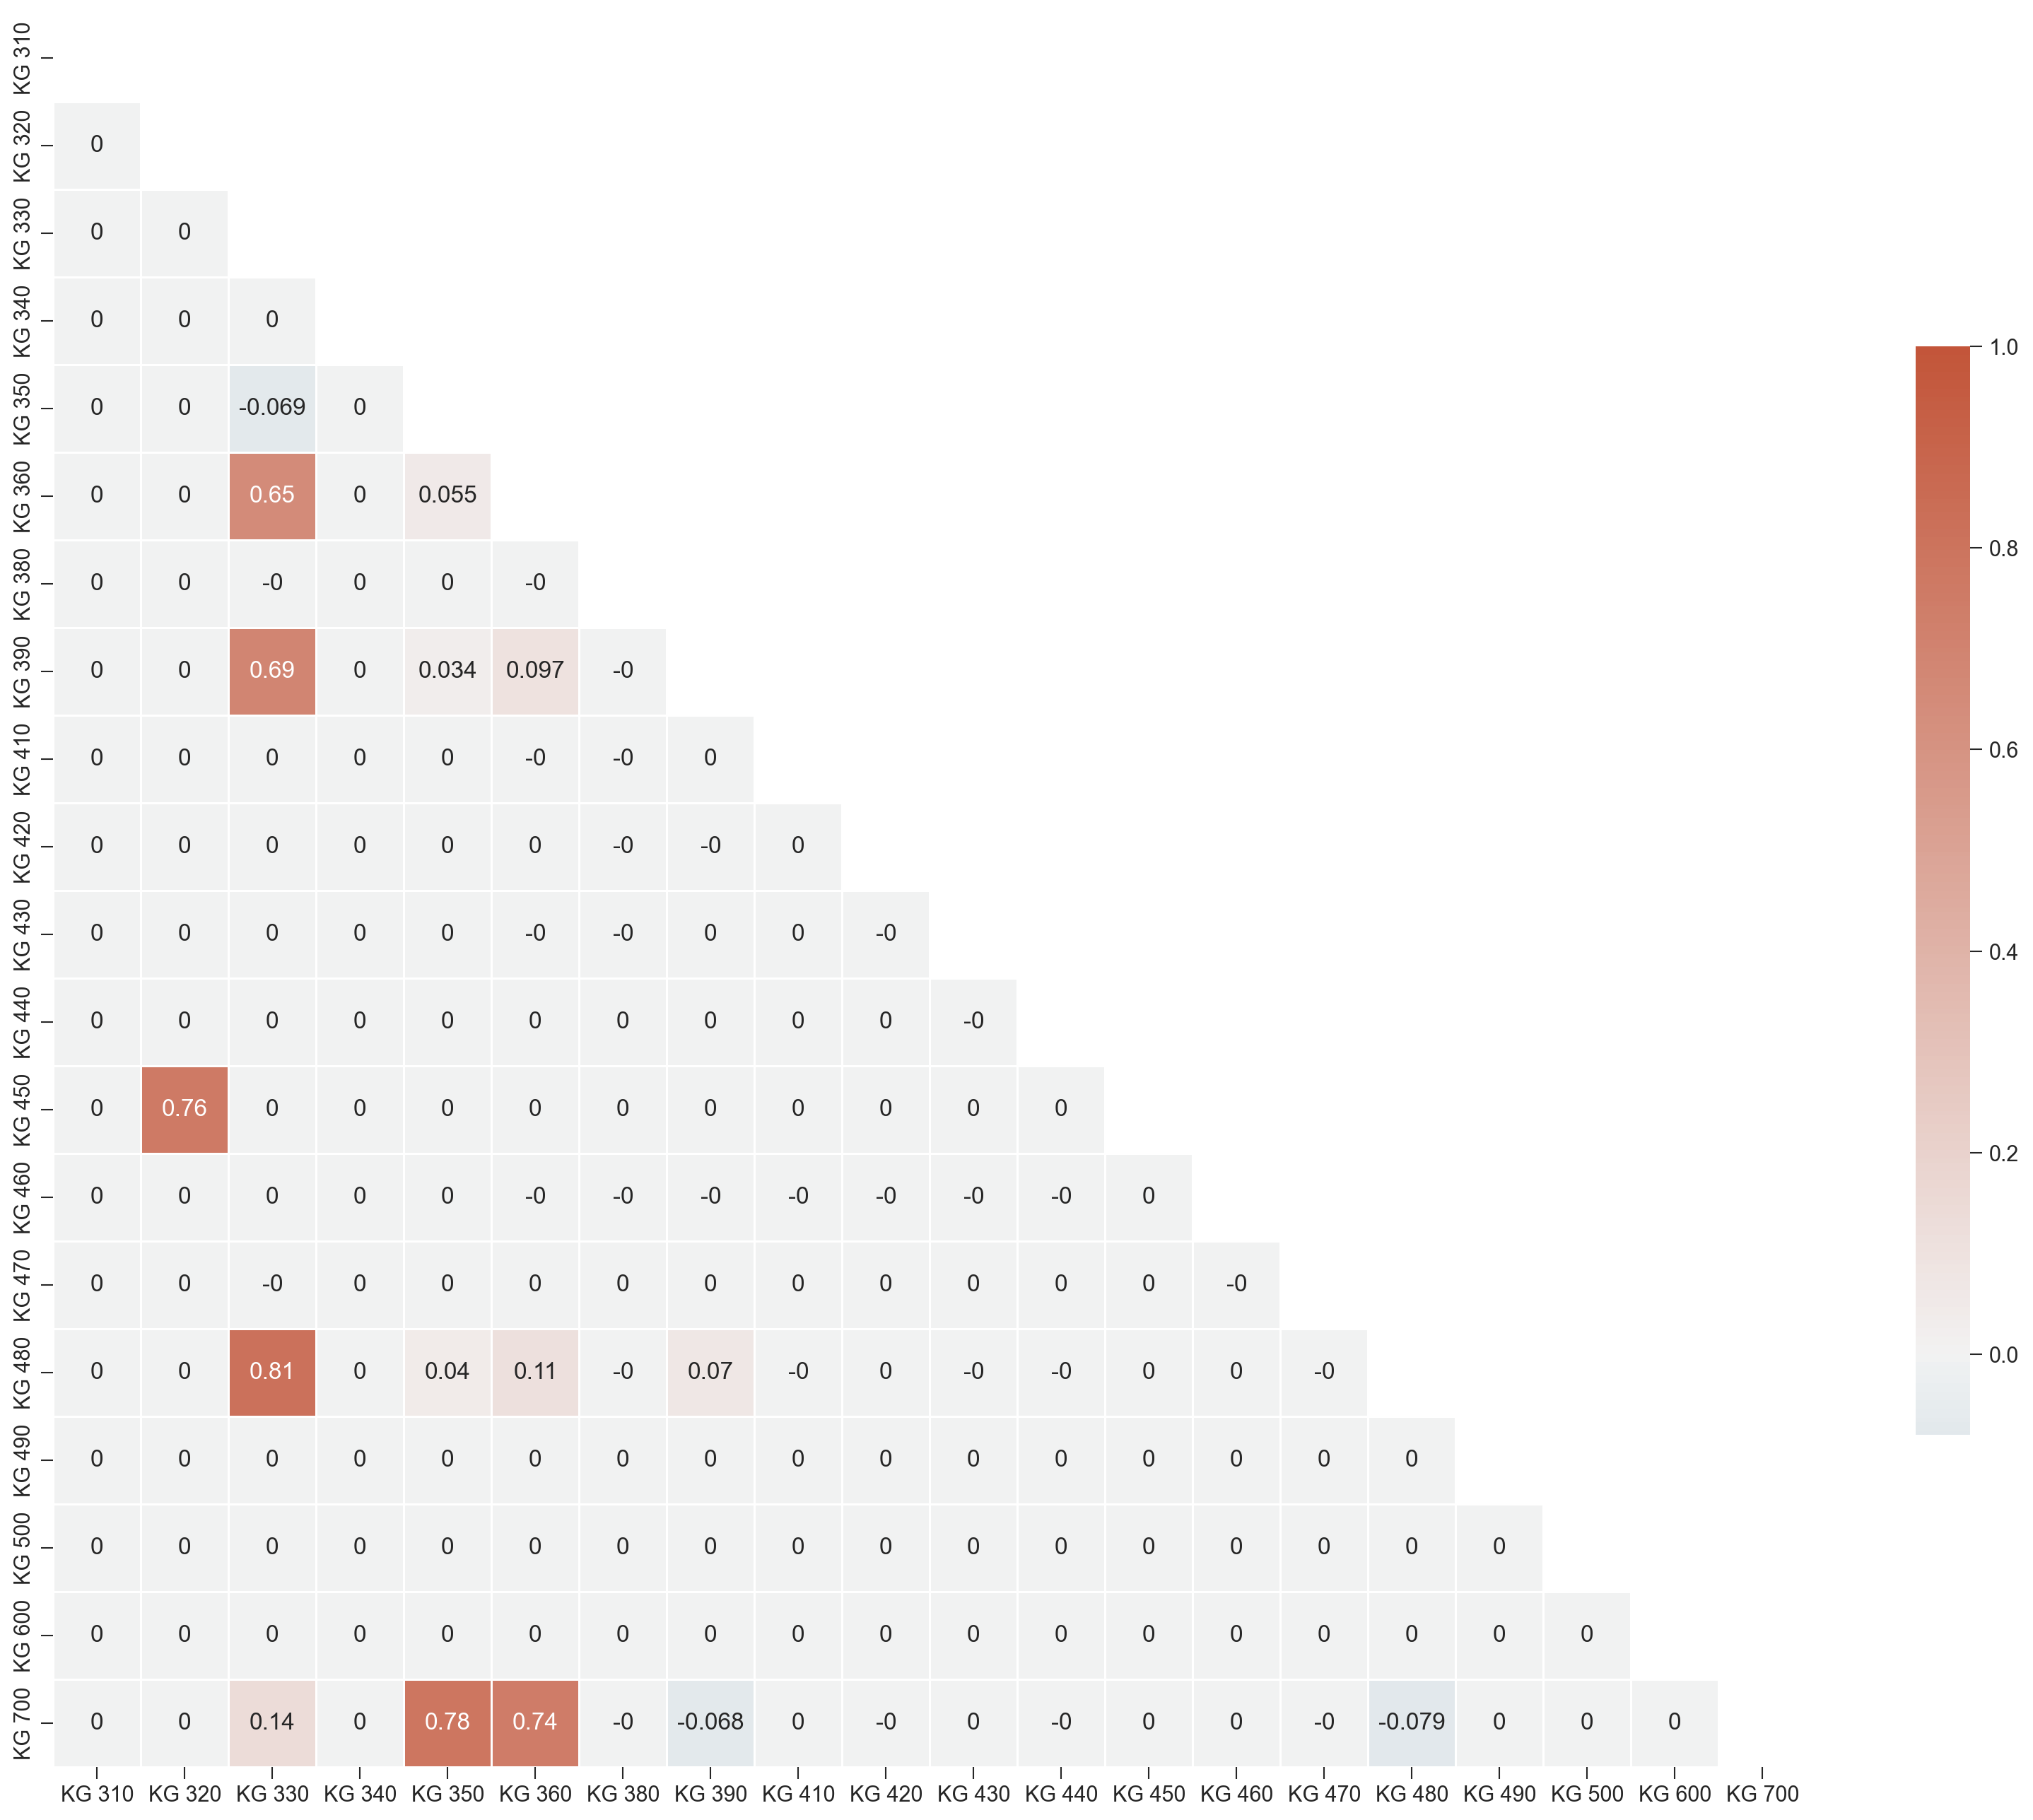

In [30]:
# plot significant correlation matrix
cmap = sns.diverging_palette(230, 20, as_cmap=True)

corr_heatmap(psd_matrix,cmap,labels_title)

In [31]:
# identity array to compare w/o correlation
identity_matrix = np.identity(20)

# Compute determinant
det = np.linalg.det(psd_matrix)

# Check for singularity
is_singular = np.isclose(det, 0)

print("Determinant:", det)
print("Singular:", is_singular)

Determinant: 1.70680311750853e-30
Singular: True


## Simulation

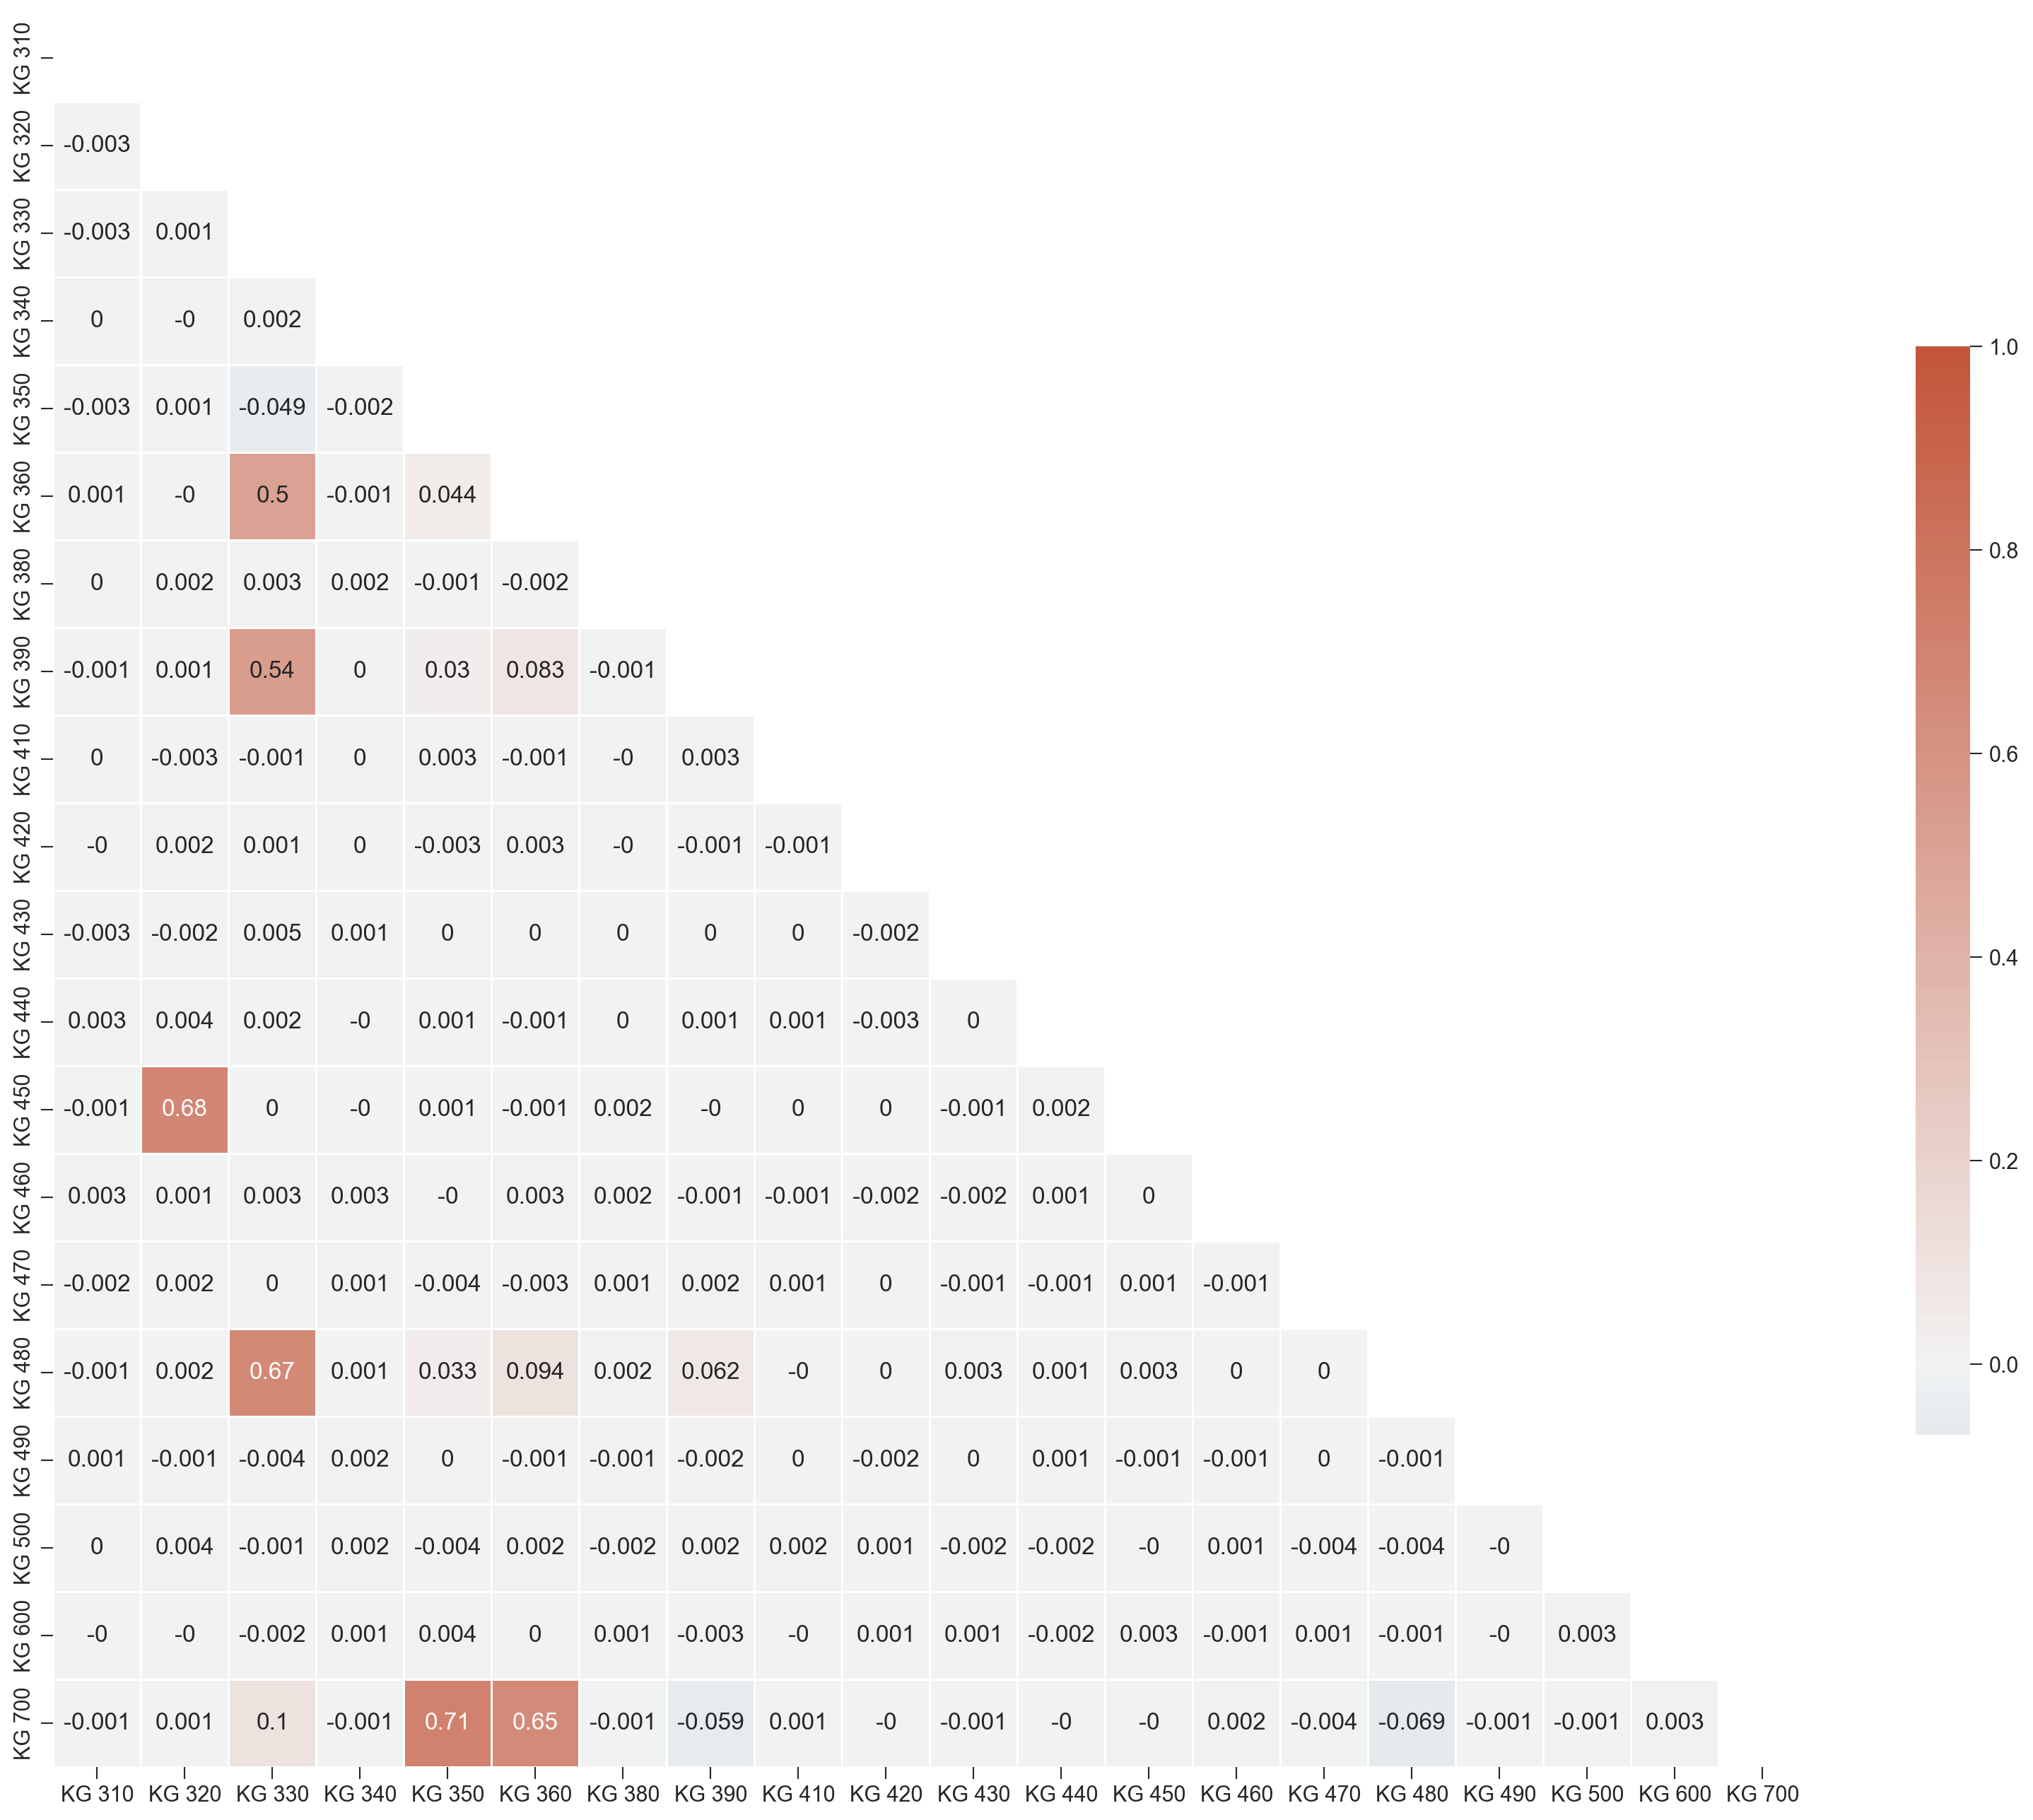

In [32]:
# induce correlation
correlate(cost_distr, psd_matrix)

# check the correlation matrix
corrcheck_matrix = correlation_matrix(cost_distr)

# plot correlation check matrix
cmap = sns.diverging_palette(230, 20, as_cmap=True)

corr_heatmap(corrcheck_matrix,cmap,labels_title)

C:\Users\Leopold\AppData\Local\Temp\ipykernel_25232\149961238.py:24: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


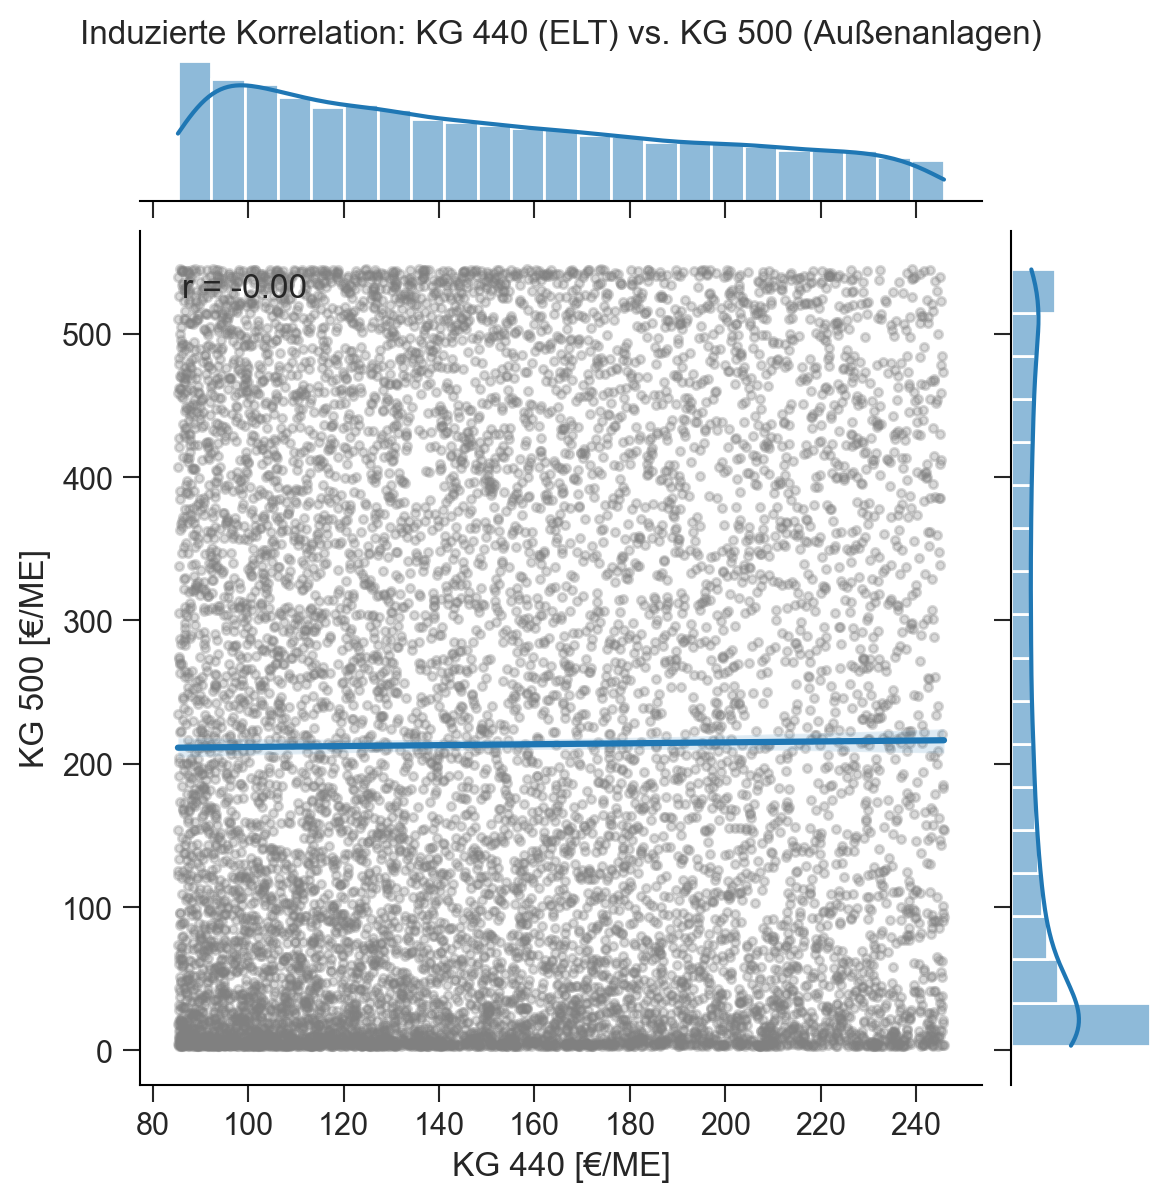

In [65]:
# check individual correlation
# select rv
x_col = 11 # 2 #11
y_col = 17 # 5 #17

sel_corr_data = pd.DataFrame(data={labels_title[x_col]+" [€/ME]": cost_distr[x_col]._mcpts, labels_title[y_col]+" [€/ME]": cost_distr[y_col]._mcpts})
sel_corr_data = sel_corr_data.drop(sel_corr_data.index[10000:])
sel_corr_data

# plot lin Regr
fig_regr = sns.jointplot(data=sel_corr_data, x=labels_title[x_col]+" [€/ME]", y=labels_title[y_col]+" [€/ME]", kind="reg", marker=".", color="gray",
                        joint_kws = {"scatter_kws":dict(alpha=0.3), "line_kws":{"color":"tab:blue"}}, marginal_kws={"color": "tab:blue"})

#plt.text(x=sel_corr_data[sel_corr_data.columns[0]].max()*0.85, y=sel_corr_data[sel_corr_data.columns[1]].max()*1, s='r = {:.2f}'.format(corrcheck_matrix[x_col][y_col]), size=15, fontweight="bold")
plt.text(
    0.05, 0.95,
    f"r = {corrcheck_matrix[x_col][y_col]:.2f}",
    transform=plt.gca().transAxes,
    ha='left', va='top',
    fontsize=12
)

plt.title(f"Induzierte Korrelation: {labels_title[x_col]} ({labels_text[x_col]}) vs. {labels_title[y_col]} ({labels_text[y_col]})", y=1.2)
plt.tight_layout()

In [34]:
# modelling cost aggregation
# adding up uncertainty variables to uncertainty function
# k_ist phase 1
k_prob = cost_phase1_det

# cost distributions phase 2
k_prob += cost_distr[0] * float(quantities_raw["kg_310_bgi"].iloc[0]) # kg 310
k_prob += cost_distr[1] * float(quantities_raw["kg_320_grf"].iloc[0]) # kg 320
k_prob += cost_distr[2] * float(quantities_raw["kg_330_awf"].iloc[0]) # kg 330
k_prob += cost_distr[3] * float(quantities_raw["kg_340_iwf"].iloc[0]) # kg 340
k_prob += cost_distr[4] * float(quantities_raw["kg_350_def"].iloc[0]) # kg 350
k_prob += cost_distr[5] * float(quantities_raw["kg_360_daf"].iloc[0]) # kg 360
k_prob += cost_distr[6] * float(quantities_raw["bgf"].iloc[0]) # kg 380
k_prob += cost_distr[7] * float(quantities_raw["bgf"].iloc[0]) # kg 390
k_prob += cost_distr[8] * float(quantities_raw["bgf"].iloc[0]) # kg 410
k_prob += cost_distr[9] * float(quantities_raw["bgf"].iloc[0]) # kg 420
k_prob += cost_distr[10] * float(quantities_raw["bgf"].iloc[0]) # kg 430
k_prob += cost_distr[11] * float(quantities_raw["bgf"].iloc[0]) # kg 440
k_prob += cost_distr[12] * float(quantities_raw["bgf"].iloc[0]) # kg 450
k_prob += cost_distr[13] * float(quantities_raw["bgf"].iloc[0]) # kg 460
k_prob += cost_distr[14] * float(quantities_raw["bgf"].iloc[0]) # kg 470
k_prob += cost_distr[15] * float(quantities_raw["bgf"].iloc[0]) # kg 480
k_prob += cost_distr[16] * float(quantities_raw["bgf"].iloc[0]) # kg 490
k_prob += cost_distr[17] * float(quantities_raw["kg_500_auf"].iloc[0]) # kg 500
k_prob += cost_distr[18] * float(quantities_raw["bgf"].iloc[0]) # kg 600
k_prob += cost_distr[19] * float(quantities_raw["bgf"].iloc[0]) # kg 700 phase 2

print(type(cost_distr[0]))
print("   |\n   |\n   |\n   V")
print(type(k_prob))


<class 'mcerp.UncertainVariable'>
   |
   |
   |
   V
<class 'mcerp.UncertainFunction'>


In [35]:
# execute mcs
k_prob_mcs = pd.DataFrame(k_prob._mcpts)
k_prob_mcs.describe()

0
count  5.000000e+04
mean   4.826136e+06
std    7.035186e+05
min    3.121842e+06
25%    4.321679e+06
50%    4.737571e+06
75%    5.225856e+06
max    9.498687e+06

C:\Users\Leopold\AppData\Local\Temp\ipykernel_25232\2908672191.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(title="n = "+"{:,}".format(n_samples).replace(',','.'), frameon=False)


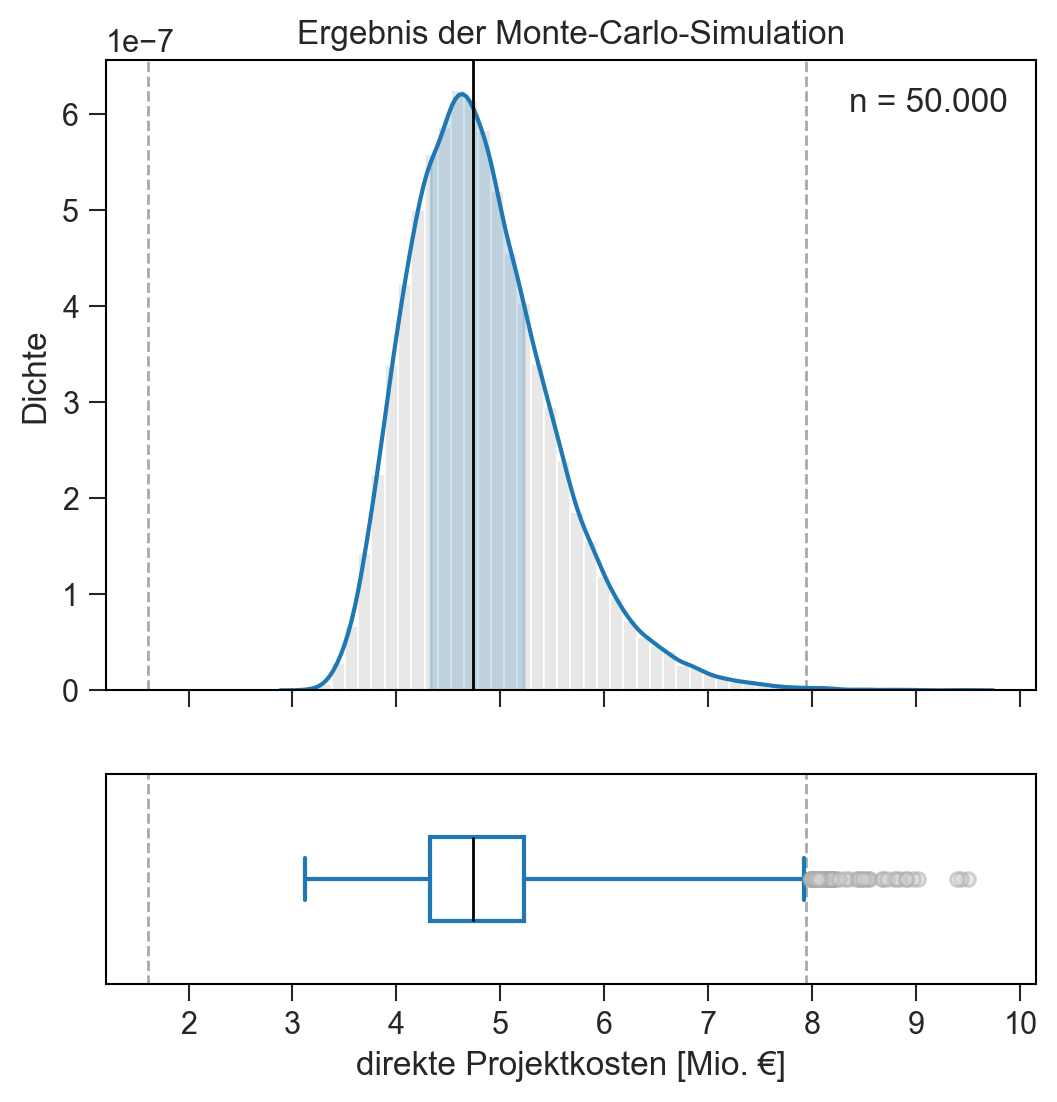

In [36]:
# mcs result
# source = https://stackoverflow.com/questions/63351594/how-to-plot-comparative-boxplot-with-a-pdf-like-kdnuggets-style
iqr_multipl = 3

x = k_prob_mcs[k_prob_mcs.columns[0]]
mean = x.mean()
std = x.std()
q1, median, q3 = np.percentile(x, [25, 50, 75])
iqr = q3 - q1

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=(6,6), dpi=200)

# distribution plot
sns.histplot(x, ax=ax1, color="lightgrey", alpha=0.5, stat="density", bins=50)
sns.kdeplot(x, ax=ax1, color="tab:blue")
kdeline = ax1.lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()

ylims = ax1.get_ylim()
#ax1.fill_between(xs, 0, ys, color='grey')
#ax1.fill_between(xs, 0, ys, where=(xs >= q1 - 1.5*iqr) & (xs <= q3 + 1.5*iqr), color='white')
ax1.fill_between(xs, 0, ys, where=(xs >= q1) & (xs <= q3), color='tab:blue', alpha=0.2)
ax1.vlines(median, ymin=0, ymax=3, color="black", linestyle="-", linewidth=1)
ax1.vlines([q1 - iqr_multipl*iqr, q3 + iqr_multipl*iqr], 0, 100, color='darkgrey', ls="--", linewidth=1, zorder=0)
ax1.set_ylim(0, ylims[1])
ax1.set(ylabel = "Dichte")

ax1.set_title("Ergebnis der Monte-Carlo-Simulation")
ax1.legend(title="n = "+"{:,}".format(n_samples).replace(',','.'), frameon=False)


# boxplot
c = "tab:blue"
boxprops = dict(edgecolor=c, facecolor="white", linewidth=1.5)
medianprops = dict(linestyle='-', color="black")
capprops = dict(color=c, linewidth=1.5)
whiskerprops = dict(color=c, linewidth=1.5)
flierprops = dict(markeredgecolor="darkgrey", markersize=5, alpha=0.5, markerfacecolor="lightgrey", linewidth=0.5)

sns.boxplot(x=x, boxprops=boxprops, medianprops=medianprops, capprops=capprops, whiskerprops=whiskerprops, flierprops=flierprops, whis=3, showfliers=True, ax=ax2)

# ticks = [mean + std * i for i in range(-4, 5)]
# ticklabels = [f'${i}\\sigma$' for i in range(-4, 5)]
# ax2.set_xticks(ticks)
# ax2.set_xticklabels(ticklabels)
ax2.set_yticks([])
ax2.tick_params(labelbottom=True) 
ax2.set_ylim(-1, 1)
# ax2.errorbar([q1, q3], [1, 1], yerr=[0.2], color='black', lw=1)
# ax2.text(q1, 0.6, 'Q1', ha='center', va='center', color='black')
# ax2.text(q3, 0.6, 'Q3', ha='center', va='center', color='black')
# ax2.text(median, -0.7, 'M', ha='center', va='center', color='black')
# ax2.text(median, 1.2, 'IQR', ha='center', va='center', color='black')
# ax2.text(q1 - 1.5*iqr, 0.4, 'Q1 - 1.5*IQR', ha='center', va='center', color='black')
# ax2.text(q3 + 1.5*iqr, 0.4, 'Q3 + 1.5*IQR', ha='center', va='center', color='black')
# ax2.vlines([q1 - 1.5*iqr, q1, q3, q3 + 1.5*iqr], 0, -2, color='darkgrey', ls=':', clip_on=False, zorder=0)
ax2.vlines([q1 - iqr_multipl*iqr, q3 + iqr_multipl*iqr], -100, 100, color='darkgrey', ls="--", linewidth=1, zorder=0)
ax2.set(xlabel = "direkte Projektkosten [Mio. €]")

ax2.xaxis.set_major_locator(ticker.MultipleLocator(1000000))
ax2.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: "{:,.0f}".format(x/1000000).replace('.',',')))

plt.show()

In [37]:
# function to remove outliers using IQR
# customize the threshold multiplier to be more or less aggressive

def remove_outliers_iqr(df, thresh=1.5):
    numeric_cols = df.select_dtypes(include='number').columns
    len0 = len(df)
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - thresh * IQR
        upper_bound = Q3 + thresh * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        print(len0 - len(df)," values removed")
    return df

In [38]:
# remove outliers

k_prob_mcs_clean = remove_outliers_iqr(k_prob_mcs, iqr_multipl)
k_prob_mcs_clean.describe()

57  values removed


0
count  4.994300e+04
mean   4.822100e+06
std    6.935774e+05
min    3.121842e+06
25%    4.320931e+06
50%    4.736638e+06
75%    5.224006e+06
max    7.923812e+06

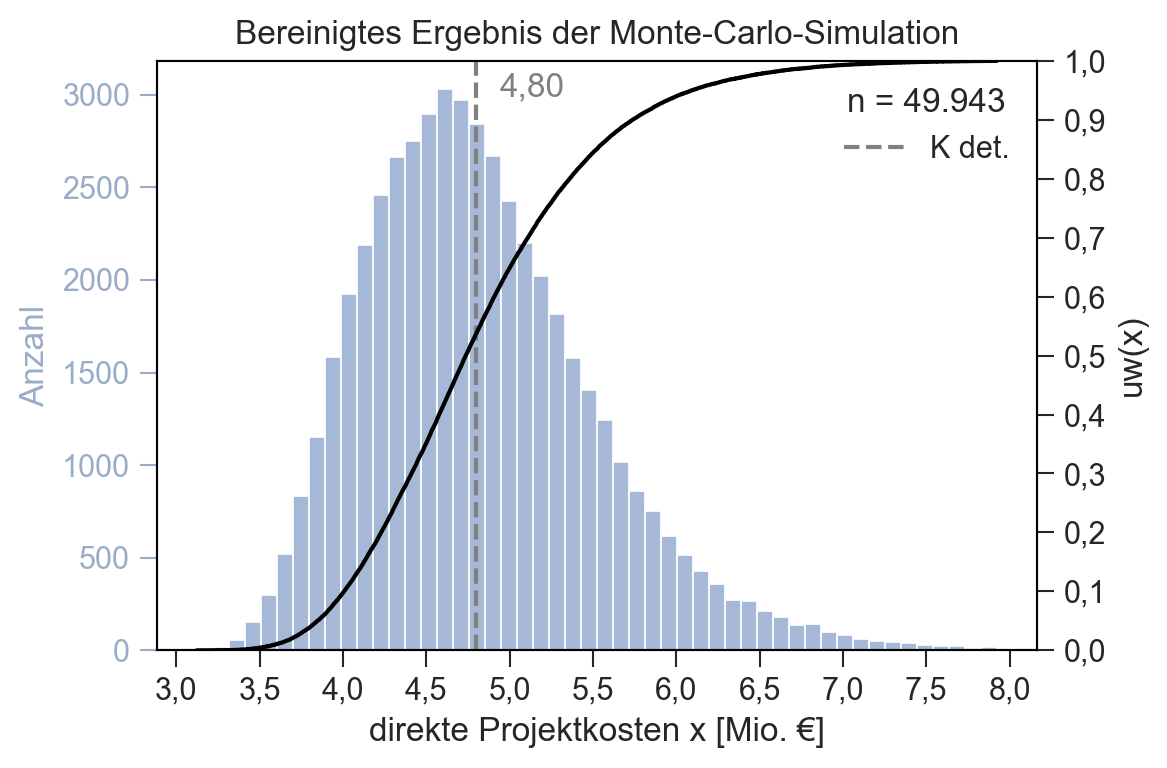

In [67]:

#plot cleaned mcs histogram
k_det = cost_phase12_det

# Create main figure and histogram axis
fig, ax1 = plt.subplots(figsize=(6, 4), dpi=200)

# Plot histogram on primary axis
fig_distr_mcs = sns.histplot(
    data=k_prob_mcs_clean,
    x=k_prob_mcs_clean.columns[0],
    cumulative=False,
    bins=50,
    kde=False,
    ax=ax1,
    alpha=0.5
)

# Get limits for annotations
ylim = ax1.get_ylim()

# Vertical line for k_det
ax1.axvline(k_det, color="grey", linestyle="--", label="K det.")
ax1.text(x=1.03*k_det, y=ylim[1] * 0.94,
         s=str("{:,.2f}".format(k_det/1000000).replace('.', ',')),
         color="grey")

# Axis labels and format
ax1.set_xlabel("direkte Projektkosten x [Mio. €]")
ax1.set_ylabel("Anzahl")
ax1.xaxis.set_major_locator(ticker.MultipleLocator(500000))
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(
    lambda x, pos: "{:,.1f}".format(x / 1_000_000).replace('.', ','))
)
ax1.tick_params(axis='y', colors='#9aacc9')
ax1.yaxis.label.set_color('#9aacc9')

# Add secondary axis for ECDF
ax2 = ax1.twinx()
sns.ecdfplot(
    data=k_prob_mcs_clean,
    x=k_prob_mcs_clean.columns[0],
    ax=ax2,
    color="black"
)
ax2.set_ylabel("uw(x)")
ax2.set_ylim(0, 1)
ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: "{:,.1f}".format(x/1).replace('.',',')))

# Title and legend
plt.title("Bereinigtes Ergebnis der Monte-Carlo-Simulation")
ax1.legend(title="n = " + "{:,}".format(len(k_prob_mcs_clean)).replace(',', '.'), frameon=False)

plt.tight_layout()
plt.show()

## Zielkostenfestlegung und Anreizgestaltung

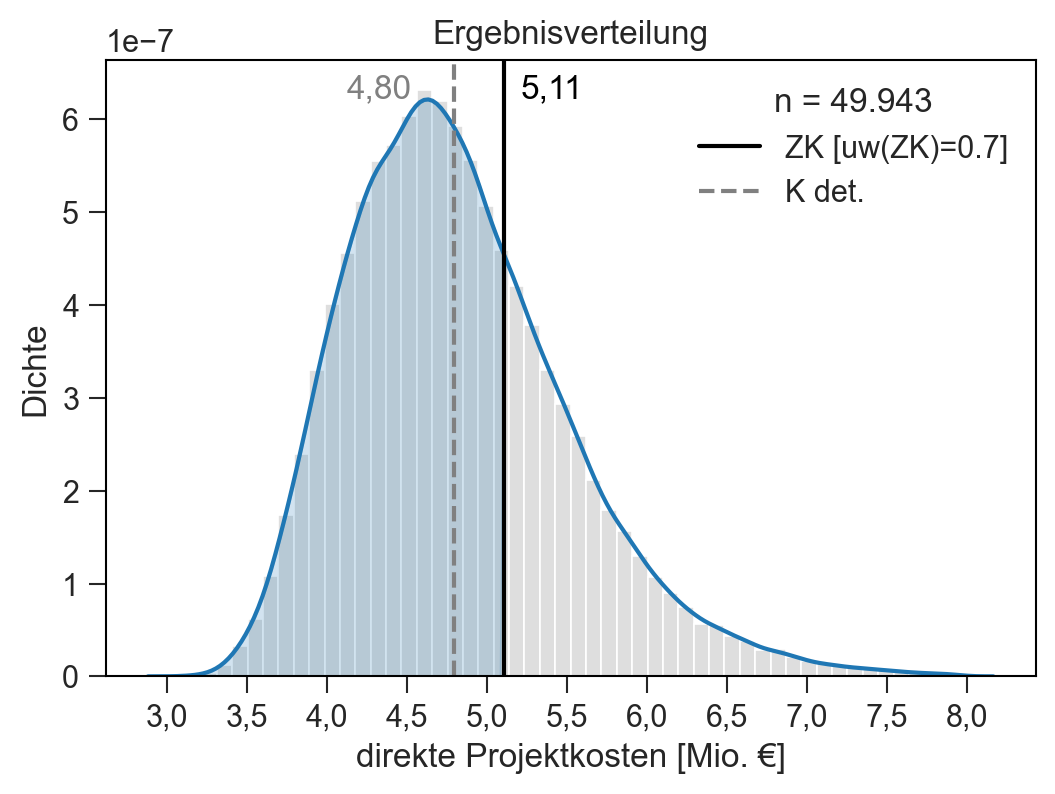

In [111]:
# plot cleaned mcs histogram with target costs
# parameters
uw_zk = 0.70
k_det = cost_phase12_det

# get VaR cost data
def cost_var(cost_aggr, quantile):
    return float(cost_aggr[cost_aggr.columns[0]].quantile(q=quantile))

zk = cost_var(k_prob_mcs_clean,uw_zk)

# plot 
plt.figure(figsize=(6,4), dpi=200)
fig_distr_mcs = sns.histplot(data=k_prob_mcs_clean.iloc[:, 0], color="lightgrey", cumulative=False, bins=50, kde=False, stat="density")
fig_kde_mcs = sns.kdeplot(data=k_prob_mcs_clean.iloc[:, 0], color="tab:blue")

# plot lines
ylim = fig_distr_mcs.get_ylim()

plt.axvline(zk, color="black", linestyle="-", label=f"ZK [uw(ZK)={uw_zk}]")
plt.text(x=1.02*zk, y=ylim[1]*0.94, s=str("{:,.2f}".format(zk/1000000).replace('.',',')), color="black")

plt.axvline(k_det, color="grey", linestyle="--", label="K det.")
plt.text(x=0.86*k_det, y=ylim[1]*0.94, s=str("{:,.2f}".format(k_det/1000000).replace('.',',')), color="grey")

# fill
line = fig_kde_mcs.lines[0]
x, y = line.get_data()
fig_kde_mcs.fill_between(x, y, where=(x < zk), interpolate=True, color="tab:blue", alpha=0.2)

# legend
plt.title("Ergebnisverteilung")
plt.legend(title="n = "+"{:,}".format(len(k_prob_mcs_clean)).replace(',','.'), 
           frameon=False
           #loc="center left",
           #bbox_to_anchor = (0.6 , 0.5)
           )

fig_distr_mcs.set(xlabel = "direkte Projektkosten [Mio. €]", ylabel = "Dichte")

# axis format
fig_distr_mcs.xaxis.set_major_locator(ticker.MultipleLocator(500000))
fig_distr_mcs.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: "{:,.1f}".format(x/1000000).replace('.',',')))

4795474.082682978 ----> 0.5345894319524258


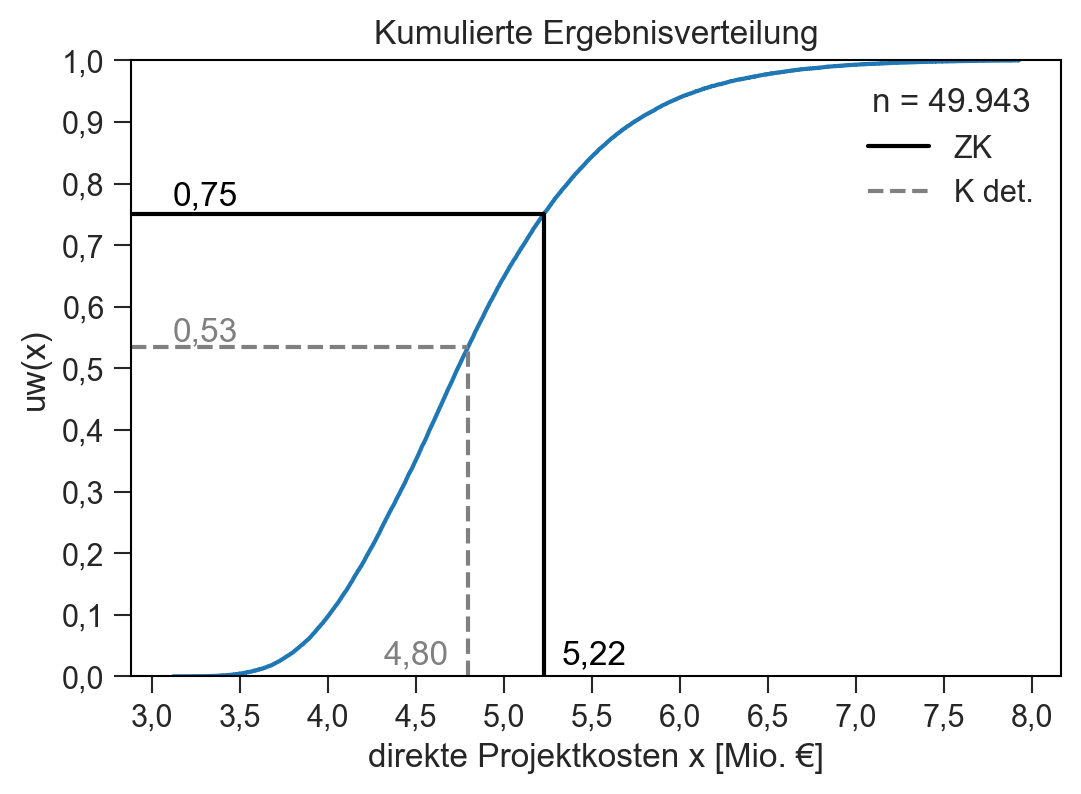

In [101]:
# plot cumulative mcs histogram with target costs

# get VaR cost data
def cost_var(cost_aggr, quantile):
    return float(cost_aggr[cost_aggr.columns[0]].quantile(q=quantile))

zk = cost_var(k_prob_mcs_clean,uw_zk)

# plot 
plt.figure(figsize=(6,4), dpi=200)
fig_distr_mcs = sns.ecdfplot(data=k_prob_mcs_clean.iloc[:, 0], color="tab:blue")

# plot data
# get det data
line = fig_distr_mcs.lines[0]
x, y = line.get_data()

cost_det_index = np.argmax(x > k_det)
k_det_prob = y[cost_det_index]
print(k_det, "---->", k_det_prob)

# plot lines
# vertical lines
ylim = fig_distr_mcs.get_ylim()
fig_distr_mcs.axes.set_ylim(0,1)

plt.axvline(x=zk, ymin=ylim[0], ymax=uw_zk, color="black", linestyle="-", label=f"ZK")
plt.text(x=1.02*zk, y=ylim[1]*0.02, s=str("{:,.2f}".format(zk/1000000).replace('.',',')), color="black")

plt.axvline(k_det, ymin=ylim[0], ymax=k_det_prob, color="grey", linestyle="--", label="K det.")
plt.text(x=0.9*k_det, y=ylim[1]*0.02, s=str("{:,.2f}".format(k_det/1000000).replace('.',',')), color="grey")

# horizontal lines
xlims = fig_distr_mcs.get_xlim()
fig_distr_mcs.axes.set_xlim(xlims)

plt.hlines(y=uw_zk, xmin=xlims[0], xmax=zk, color="black")
plt.text(x=0.65*k_det, y=uw_zk*1.02, s=str("{:,.2f}".format(uw_zk).replace('.',',')), color="black")

plt.hlines(y=k_det_prob, xmin=xlims[0], xmax=k_det, color="grey", linestyle="--")
plt.text(x=0.65*k_det, y=k_det_prob*1.02, s=str("{:,.2f}".format(k_det_prob).replace('.',',')), color="grey")

# legend
plt.title("Kumulierte Ergebnisverteilung")
plt.legend(title="n = "+"{:,}".format(len(k_prob_mcs_clean)).replace(',','.'), frameon=False)

fig_distr_mcs.set(xlabel = "direkte Projektkosten x [Mio. €]", ylabel = "uw(x)")

# axis format
fig_distr_mcs.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
fig_distr_mcs.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: "{:,.1f}".format(x/1).replace('.',',')))

fig_distr_mcs.xaxis.set_major_locator(ticker.MultipleLocator(500000))
fig_distr_mcs.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: "{:,.1f}".format(x/1000000).replace('.',',')))

4795474.082682978 ----> 0.5345894319524258


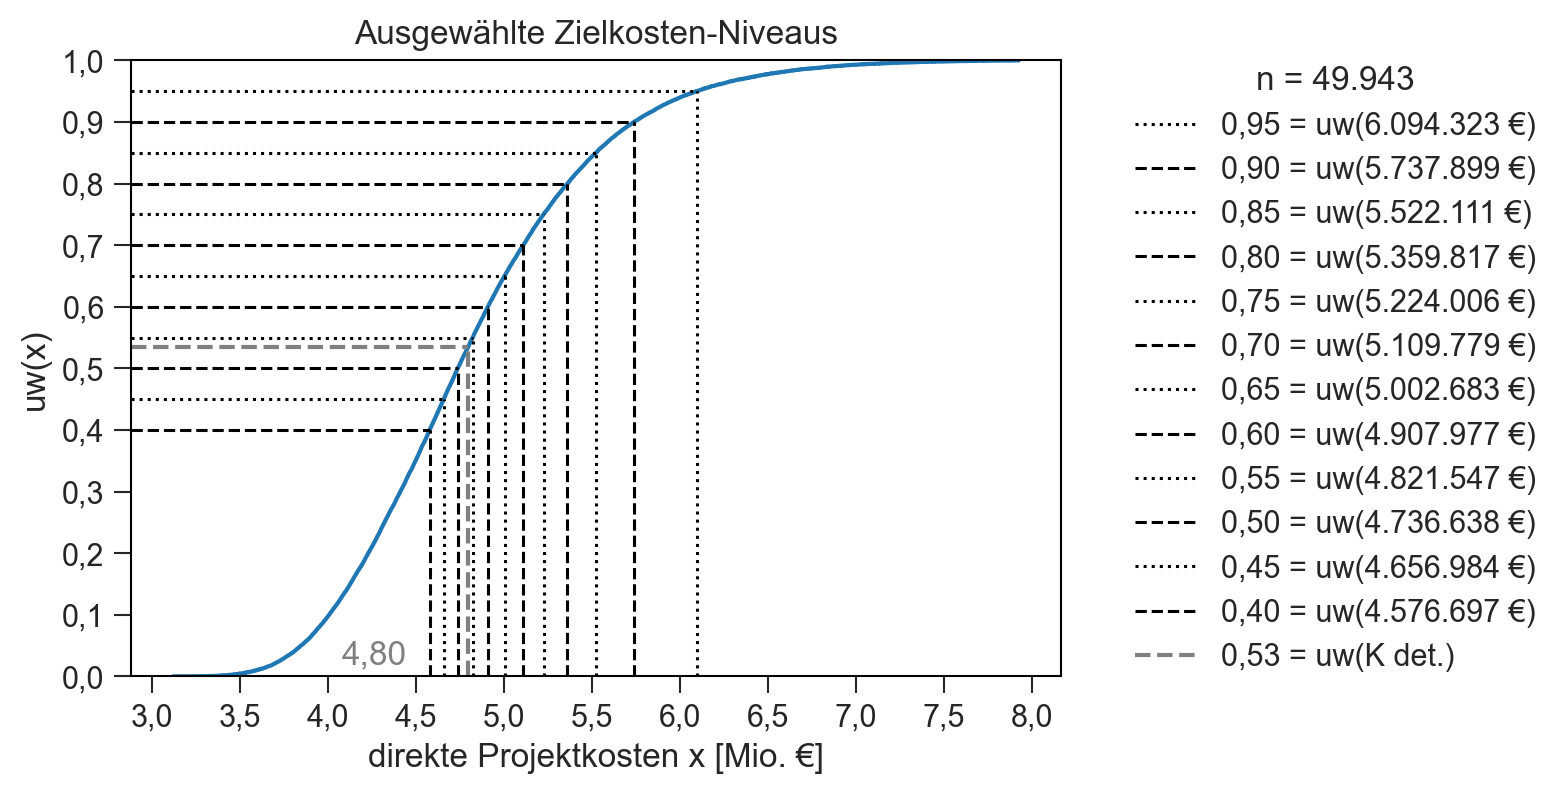

In [102]:
# plot cumulative mcs histogram with target costs

# get VaR cost data
def cost_var(cost_aggr, quantile):
    return float(cost_aggr[cost_aggr.columns[0]].quantile(q=quantile))

zk = cost_var(k_prob_mcs_clean,uw_zk)

# plot 
plt.figure(figsize=(6,4), dpi=200)
fig_distr_mcs = sns.ecdfplot(data=k_prob_mcs_clean.iloc[:, 0], color="tab:blue")

# plot data
# get det data
line = fig_distr_mcs.lines[0]
x, y = line.get_data()

cost_det_index = np.argmax(x > k_det)
k_det_prob = y[cost_det_index]
print(k_det, "---->", k_det_prob)

# vertical lines
ylim = fig_distr_mcs.get_ylim()
fig_distr_mcs.axes.set_ylim(0,1)

# horizontal lines
xlims = fig_distr_mcs.get_xlim()
fig_distr_mcs.axes.set_xlim(xlims)

# potential target costs function

def plot_var_lines(ax, cost_data, quantiles, ylim, xlims, ls):
    for i, q in enumerate(quantiles):
        var_val = cost_var(cost_data, q)
        var_label = "{:,.0f}".format(var_val).replace(',', '.')
        ax.axvline(x=var_val, ymin=ylim[0], ymax=q, color="black", linestyle=ls[i], label=f"{q:.2f}".replace('.', ',')+f" = uw({var_label} €)", linewidth=1.1)
        ax.hlines(y=q, xmin=xlims[0], xmax=var_val, color="black", linestyle=ls[i], linewidth=1.1)

# plot potential traget costs
quantiles_to_plot = [0.95, 0.90, 0.85, 0.80, 0.75, 0.70, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4]
linestyles = [":","--",":","--",":","--",":","--",":","--",":","--"]
plot_var_lines(ax=plt.gca(), cost_data=k_prob_mcs_clean, quantiles=quantiles_to_plot, ylim=ylim, xlims=xlims, ls=linestyles)

# det costs
plt.axvline(k_det, ymin=ylim[0], ymax=k_det_prob, color="grey", linestyle="--", label=f"{round(k_det_prob,2)}".replace('.',',')+" = uw(K det.)")
plt.text(x=0.85*k_det, y=ylim[1]*0.02, s=str("{:,.2f}".format(k_det/1000000).replace('.',',')), color="grey")
plt.hlines(y=k_det_prob, xmin=xlims[0], xmax=k_det, color="grey", linestyle="--")

# legend
plt.title("Ausgewählte Zielkosten-Niveaus")
plt.legend(title="n = "+"{:,}".format(len(k_prob_mcs_clean)).replace(',','.'), 
           frameon=False,
           loc="center left",
           bbox_to_anchor = (1.05 , 0.5))

fig_distr_mcs.set(xlabel = "direkte Projektkosten x [Mio. €]", ylabel = "uw(x)")

# axis format
fig_distr_mcs.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
fig_distr_mcs.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: "{:,.1f}".format(x/1).replace('.',',')))

fig_distr_mcs.xaxis.set_major_locator(ticker.MultipleLocator(500000))
fig_distr_mcs.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: "{:,.1f}".format(x/1000000).replace('.',',')))

0.7  ---->  0.44999999999999996


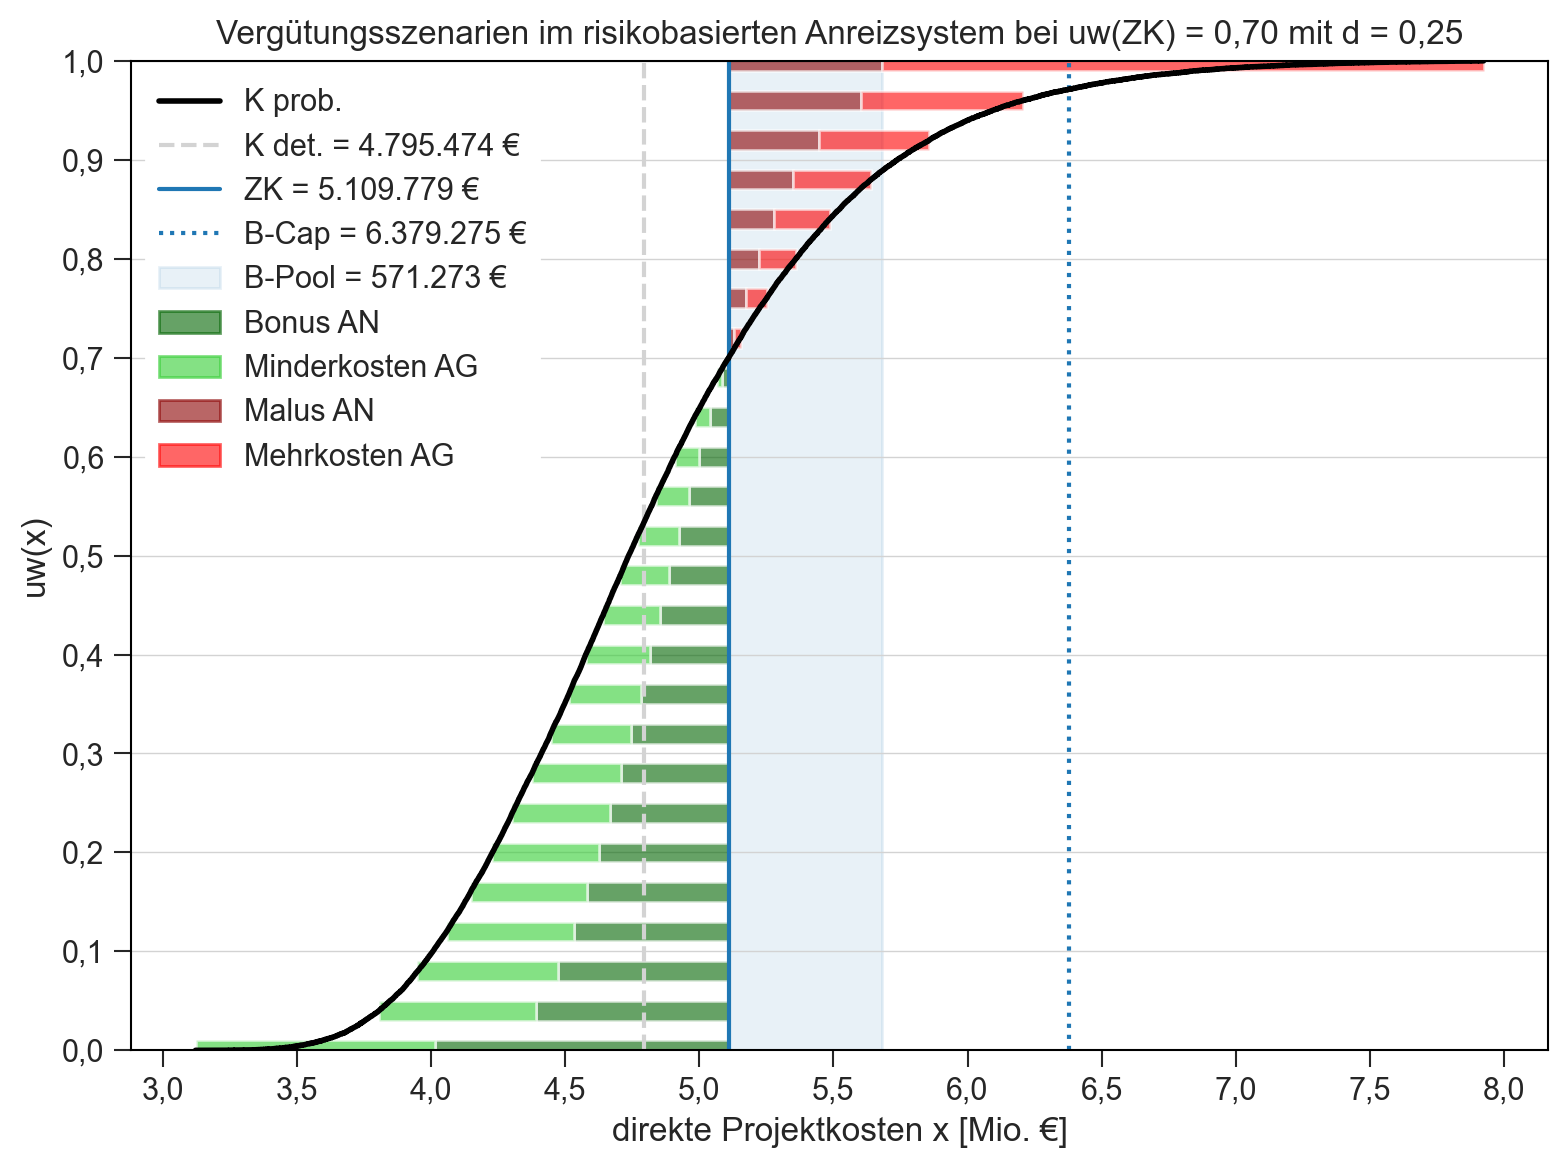

In [112]:
# Risk based incentive scheme plot
# Parameters
d = 0.25
uw_zk_d = uw_zk - d # overwrite incentive ratio 
print(uw_zk," ----> ",uw_zk_d)
b_pool = bb_prob
b_cap = zk + (zk * b_pool) / uw_zk_d

# Create the figure and axis objects
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot the CDF using seaborn
sns.ecdfplot(data=k_prob_mcs_clean.iloc[:, 0], color="black", ax=ax1, label="K prob.", linewidth=2)

# Label formatting
ax1.set_xlabel("direkte Projektkosten x [Mio. €]")
ax1.set_ylabel("uw(x)")
ax1.set_title(f"Vergütungsszenarien im risikobasierten Anreizsystem bei uw(ZK) = {uw_zk:.2f} mit d = {d:.2f}".replace(".",","))

# Extract sorted data and empirical CDF from the plotted data
sorted_data = np.sort(k_prob_mcs_clean.iloc[:, 0].values)
cdf = np.linspace(0, 1, len(sorted_data))

# Add a secondary vertical axis for bar logic
ax2 = ax1.twinx()

# Draw vertical lines
ax2.axvline(k_det, color="lightgrey", linestyle="--", label=f"K det. = {round(k_det, 0):,.0f} €".replace(",","."), zorder=2)
ax2.axvline(zk, color="tab:blue", linestyle="-", label=f"ZK = {round(zk, 0):,.0f} €".replace(",","."), zorder=2)
ax2.axvline(b_cap, color="tab:blue", linestyle=":", label=f"B-Cap = {round(b_cap, 0):,.0f} €".replace(",","."), zorder=2)

# Draw b-pool filling
ax2.axvspan(zk, zk * (1+b_pool), color="tab:blue", alpha=0.1, zorder=0, label=f"B-Pool = {round(zk * b_pool, 0):,.0f} €".replace(",","."))

# Match axis limits
ax2.set_xlim(ax1.get_xlim())
ax2.set_ylim(ax1.get_ylim())

# Bar calculations
y_values = np.arange(0.00, 1.05, 0.04).tolist() # 3rd value to chance vertical bar spacing
bar_part1 = []
bar_part2 = []

for y_value in y_values:
    bar_length = np.interp(y_value, cdf, sorted_data) - zk

    if bar_length < 0:
        bar_part1.append(bar_length * (1 - uw_zk_d))      
        bar_part2.append(bar_length * uw_zk_d)
    elif bar_length * uw_zk_d + zk < zk * (1+b_pool):
        bar_part1.append(bar_length * uw_zk_d)      
        bar_part2.append(bar_length * (1 - uw_zk_d))
    else:
        bar_part1.append(zk * b_pool)     
        bar_part2.append(bar_length - zk * b_pool)

# Plot horizontal bars
legend_handles = []
added_colors = set()

for y, part1, part2 in zip(y_values, bar_part1, bar_part2):
    color1 = "darkred" if part1 >= 0 else "darkgreen"
    color2 = "red" if part2 >= 0 else "limegreen"

    # First segment
    ax2.barh(y, part1, left=zk, color=color1, alpha=0.6, height=0.02, zorder=1)
    if color1 not in added_colors:
        legend_handles.append(mpatches.Patch(color=color1, alpha=0.6, label="Malus AN" if part1 >= 0 else "Bonus AN"))
        added_colors.add(color1)

    # Second segment
    ax2.barh(y, part2, left=zk + part1, color=color2, alpha=0.6, height=0.02, zorder=1)
    if color2 not in added_colors:
        legend_handles.append(mpatches.Patch(color=color2, alpha=0.6, label="Mehrkosten AG" if part2 >= 0 else "Minderkosten AG"))
        added_colors.add(color2)

# Axis and legend adjustments
ax2.set_axis_off()
ax1.set_zorder(ax2.get_zorder() + 1)
ax1.patch.set_visible(False)
ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: "{:,.1f}".format(x/1).replace(".",",")))

ax1.xaxis.set_major_locator(ticker.MultipleLocator(500000))
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: "{:,.1f}".format(x/1000000).replace('.',',')))

# Combine legend entries
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
combined_handles = handles1 + handles2 + legend_handles
legend = ax1.legend(handles=combined_handles, loc="upper left", frameon=True)
legend.get_frame().set_facecolor("white")
legend.get_frame().set_edgecolor("white")
legend.get_frame().set_alpha(1)

# Add horizontal grid lines
for y in ax1.get_yticks():
    ax2.axhline(y=y, color="lightgrey", linestyle="-", linewidth=0.5, zorder=0)

fig.tight_layout()
plt.show()